In [198]:
import array_to_latex
from openeye import oechem, oemolprop, oegraphsim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pickle
from rdkit import Chem, SimDivFilters, DataStructs
from rdkit.Chem import AllChem, Descriptors
from scipy import stats
from scipy.spatial.distance import euclidean, cityblock
import seaborn as sns

%matplotlib inline

In [3]:
pamine_df = pd.read_csv('../files/pamine_df.csv')
pAA_df = pd.read_csv('../files/pamino_acid_df.csv')
cooh_df = pd.read_csv('../files/cooh_df.csv')

df = pd.read_csv('../files/truncates_UMAP.csv')

In [4]:
pamine_umap = pamine_df.merge(df, on='truncate_SMILES')
pAA_umap = pAA_df.merge(df, on='truncate_SMILES')
cooh_umap = cooh_df.merge(df, on='truncate_SMILES')

In [200]:
print(len(pamine_umap))
print(len(pAA_umap))
print(len(cooh_umap))

21109
1396
31091


In [84]:
pAA_umap.loc[pAA_umap['truncate_SMILES'] == 'c1ccsc1']

,ID,Price_250mg,BB_SMILES,truncate_SMILES,X,Y
352,EN300-650073,1445.0,c1ccc2c(c1)-c3ccccc3C2COC(=O)Nc4cc(cs4)C(=O)O,c1ccsc1,8.226752,-2.18297
353,EN300-6737225,601.0,c1ccc2c(c1)-c3ccccc3C2COC(=O)Nc4ccsc4C(=O)O,c1ccsc1,8.226752,-2.18297
354,EN300-6737175,666.0,c1ccc2c(c1)-c3ccccc3C2COC(=O)Nc4c(ccs4)C(=O)O,c1ccsc1,8.226752,-2.18297
355,EN300-7313419,672.0,c1ccc2c(c1)-c3ccccc3C2COC(=O)Nc4cscc4C(=O)O,c1ccsc1,8.226752,-2.18297


In [5]:
def kde_estimate(df):
    x_ = np.array(df['X'])
    y_ = np.array(df['Y'])
    
    kernel = stats.gaussian_kde([x_, y_])
    z_ = kernel([x_, y_])
    
    return z_

### Figure 2: Comparison of $1^{o}$ amino and $1^{o}$ amine building blocks

In [6]:
z_pamine = kde_estimate(pamine_umap)
z_pAA = kde_estimate(pAA_umap)
z_cooh = kde_estimate(cooh_umap)

In [7]:
xlim = [-5.5, 20.5]
ylim = [-8, 11]

In [8]:
### Convert densities to the same range

t_min = np.min([np.min(z_pamine), np.min(z_pAA), np.min(z_cooh)])
t_max = np.max([np.max(z_pamine), np.max(z_pAA), np.max(z_cooh)])

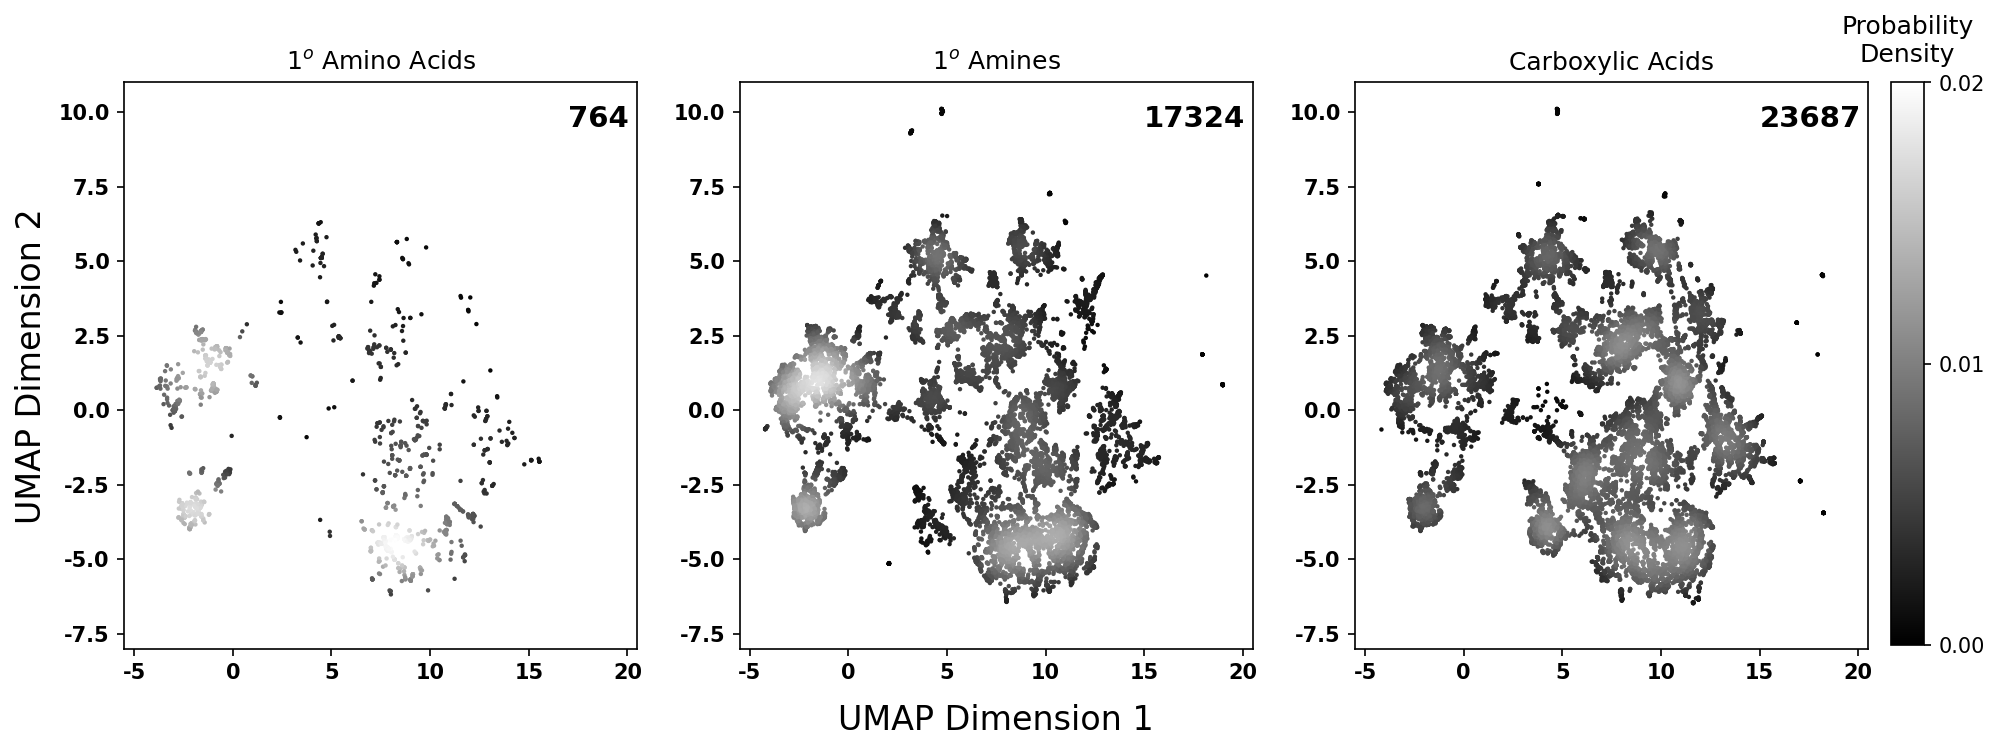

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=150)
for ax in axs.reshape(-1):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

cmap_color='gray'

sc = axs[0].scatter(pAA_umap['X'], pAA_umap['Y'], c=z_pAA, s=5, cmap=cmap_color, marker='.',
                   vmin=t_min, vmax=t_max)
axs[1].scatter(pamine_umap['X'], pamine_umap['Y'], c=z_pamine, s=5, cmap=cmap_color, marker='.',
               vmin=t_min, vmax=t_max)
axs[2].scatter(cooh_umap['X'], cooh_umap['Y'], c=z_cooh, s=5, cmap=cmap_color, marker='.',
               vmin=t_min, vmax=t_max)

axs[0].text(17, 9.5, f"{len(set(pAA_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[1].text(15, 9.5, f"{len(set(pamine_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[2].text(15, 9.5, f"{len(set(cooh_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')

axs[1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16, rotation=0)
axs[0].set_ylabel('UMAP Dimension 2', labelpad=5, fontsize=16)

axs[0].set_xticks(np.arange(-5, 25, 5))
axs[0].set_xticklabels(np.arange(-5, 25, 5), fontweight='bold')

axs[0].set_yticks(np.arange(-7.5, 12.5, 2.5))
axs[0].set_yticklabels(np.arange(-7.5, 12.5, 2.5), fontweight='bold')

axs[1].set_xticks(np.arange(-5, 25, 5))
axs[1].set_xticklabels(np.arange(-5, 25, 5), fontweight='bold')

axs[1].set_yticks(np.arange(-7.5, 12.5, 2.5))
axs[1].set_yticklabels(np.arange(-7.5, 12.5, 2.5), fontweight='bold')

axs[2].set_xticks(np.arange(-5, 25, 5))
axs[2].set_xticklabels(np.arange(-5, 25, 5), fontweight='bold')

axs[2].set_yticks(np.arange(-7.5, 12.5, 2.5))
axs[2].set_yticklabels(np.arange(-7.5, 12.5, 2.5), fontweight='bold')

axs[0].set_title("$1^o$ Amino Acids")
axs[1].set_title("$1^o$ Amines")
axs[2].set_title("Carboxylic Acids")

n_ticks = 3
cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
cbar_ax.set_title("Probability\nDensity", pad=10)

cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_ticks(np.linspace(t_min, t_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(t_min, t_max, n_ticks)])
#fig.savefig('figures/pAA_vs_pamine.png')
#fig.savefig('figures/pAA_vs_pamine.svg')
plt.show()

### SI Select Sample Compounds in Specified Region

In [25]:
c1_xmin, c1_xmax, c1_ymin, c1_ymax = -3, -1.2, -5, -2.6
pAA_cluster_1 = pAA_umap.loc[(pAA_umap['X']>c1_xmin)&(pAA_umap['X']<c1_xmax)
                           &(pAA_umap['Y']>c1_ymin)&(pAA_umap['Y']<c1_ymax)]

c2_xmin, c2_xmax, c2_ymin, c2_ymax = -2.5, -0.8, 0.4, 2
pAA_cluster_2 = pAA_umap.loc[(pAA_umap['X']>c2_xmin)&(pAA_umap['X']<c2_xmax)
                           &(pAA_umap['Y']>c2_ymin)&(pAA_umap['Y']<c2_ymax)]

c3_xmin, c3_xmax, c3_ymin, c3_ymax = 3.6, 5.5, 4.5, 6
pAA_cluster_3 = pAA_umap.loc[(pAA_umap['X']>c3_xmin)&(pAA_umap['X']<c3_xmax)
                           &(pAA_umap['Y']>c3_ymin)&(pAA_umap['Y']<c3_ymax)]

c4_xmin, c4_xmax, c4_ymin, c4_ymax = 3.4, 5.2, -0.5, 1
pAA_cluster_4 = pAA_umap.loc[(pAA_umap['X']>c4_xmin)&(pAA_umap['X']<c4_xmax)
                           &(pAA_umap['Y']>c4_ymin)&(pAA_umap['Y']<c4_ymax)]

c5_xmin, c5_xmax, c5_ymin, c5_ymax = 3.2, 5.1, -5, -2.5
pAA_cluster_5 = pAA_umap.loc[(pAA_umap['X']>c5_xmin)&(pAA_umap['X']<c5_xmax)
                           &(pAA_umap['Y']>c5_ymin)&(pAA_umap['Y']<c5_ymax)]

c6_xmin, c6_xmax, c6_ymin, c6_ymax = 7, 8.8, -5.3, -3.6
pAA_cluster_6 = pAA_umap.loc[(pAA_umap['X']>c6_xmin)&(pAA_umap['X']<c6_xmax)
                           &(pAA_umap['Y']>c6_ymin)&(pAA_umap['Y']<c6_ymax)]

c7_xmin, c7_xmax, c7_ymin, c7_ymax = 10.2, 12.1, -0.5, 1.5
pAA_cluster_7 = pAA_umap.loc[(pAA_umap['X']>c7_xmin)&(pAA_umap['X']<c7_xmax)
                           &(pAA_umap['Y']>c7_ymin)&(pAA_umap['Y']<c7_ymax)]

c8_xmin, c8_xmax, c8_ymin, c8_ymax = 12.5, 15, -2, 0
pAA_cluster_8 = pAA_umap.loc[(pAA_umap['X']>c8_xmin)&(pAA_umap['X']<c8_xmax)
                           &(pAA_umap['Y']>c8_ymin)&(pAA_umap['Y']<c8_ymax)]

In [26]:
c1_xmin, c1_xmax, c1_ymin, c1_ymax = -3, -1.2, -5, -2.6
pamine_cluster_1 = pamine_umap.loc[(pamine_umap['X']>c1_xmin)&(pamine_umap['X']<c1_xmax)
                           &(pamine_umap['Y']>c1_ymin)&(pamine_umap['Y']<c1_ymax)]

c2_xmin, c2_xmax, c2_ymin, c2_ymax = -2.5, -0.8, 0.4, 2
pamine_cluster_2 = pamine_umap.loc[(pamine_umap['X']>c2_xmin)&(pamine_umap['X']<c2_xmax)
                           &(pamine_umap['Y']>c2_ymin)&(pamine_umap['Y']<c2_ymax)]

c3_xmin, c3_xmax, c3_ymin, c3_ymax = 3.6, 5.5, 4.5, 6
pamine_cluster_3 = pamine_umap.loc[(pamine_umap['X']>c3_xmin)&(pamine_umap['X']<c3_xmax)
                           &(pamine_umap['Y']>c3_ymin)&(pamine_umap['Y']<c3_ymax)]

c4_xmin, c4_xmax, c4_ymin, c4_ymax = 3.4, 5.2, -0.5, 1
pamine_cluster_4 = pamine_umap.loc[(pamine_umap['X']>c4_xmin)&(pamine_umap['X']<c4_xmax)
                           &(pamine_umap['Y']>c4_ymin)&(pamine_umap['Y']<c4_ymax)]

c5_xmin, c5_xmax, c5_ymin, c5_ymax = 3.2, 5.1, -5, -2.5
pamine_cluster_5 = pamine_umap.loc[(pamine_umap['X']>c5_xmin)&(pamine_umap['X']<c5_xmax)
                           &(pamine_umap['Y']>c5_ymin)&(pamine_umap['Y']<c5_ymax)]

c6_xmin, c6_xmax, c6_ymin, c6_ymax = 7, 8.8, -5.3, -3.6
pamine_cluster_6 = pamine_umap.loc[(pamine_umap['X']>c6_xmin)&(pamine_umap['X']<c6_xmax)
                           &(pamine_umap['Y']>c6_ymin)&(pamine_umap['Y']<c6_ymax)]

c7_xmin, c7_xmax, c7_ymin, c7_ymax = 10.2, 12.1, -0.5, 1.5
pamine_cluster_7 = pamine_umap.loc[(pamine_umap['X']>c7_xmin)&(pamine_umap['X']<c7_xmax)
                           &(pamine_umap['Y']>c7_ymin)&(pamine_umap['Y']<c7_ymax)]

c8_xmin, c8_xmax, c8_ymin, c8_ymax = 12.5, 15, -2, 0
pamine_cluster_8 = pamine_umap.loc[(pamine_umap['X']>c8_xmin)&(pamine_umap['X']<c8_xmax)
                           &(pamine_umap['Y']>c8_ymin)&(pamine_umap['Y']<c8_ymax)]

In [27]:
c1_xmin, c1_xmax, c1_ymin, c1_ymax = -3, -1.2, -5, -2.6
cooh_cluster_1 = cooh_umap.loc[(cooh_umap['X']>c1_xmin)&(cooh_umap['X']<c1_xmax)
                           &(cooh_umap['Y']>c1_ymin)&(cooh_umap['Y']<c1_ymax)]

c2_xmin, c2_xmax, c2_ymin, c2_ymax = -2.5, -0.8, 0.4, 2
cooh_cluster_2 = cooh_umap.loc[(cooh_umap['X']>c2_xmin)&(cooh_umap['X']<c2_xmax)
                           &(cooh_umap['Y']>c2_ymin)&(cooh_umap['Y']<c2_ymax)]

c3_xmin, c3_xmax, c3_ymin, c3_ymax = 3.6, 5.5, 4.5, 6
cooh_cluster_3 = cooh_umap.loc[(cooh_umap['X']>c3_xmin)&(cooh_umap['X']<c3_xmax)
                           &(cooh_umap['Y']>c3_ymin)&(cooh_umap['Y']<c3_ymax)]

c4_xmin, c4_xmax, c4_ymin, c4_ymax = 3.4, 5.2, -0.5, 1
cooh_cluster_4 = cooh_umap.loc[(cooh_umap['X']>c4_xmin)&(cooh_umap['X']<c4_xmax)
                           &(cooh_umap['Y']>c4_ymin)&(cooh_umap['Y']<c4_ymax)]

c5_xmin, c5_xmax, c5_ymin, c5_ymax = 3.2, 5.1, -5, -2.5
cooh_cluster_5 = cooh_umap.loc[(cooh_umap['X']>c5_xmin)&(cooh_umap['X']<c5_xmax)
                           &(cooh_umap['Y']>c5_ymin)&(cooh_umap['Y']<c5_ymax)]

c6_xmin, c6_xmax, c6_ymin, c6_ymax = 7, 8.8, -5.3, -3.6
cooh_cluster_6 = cooh_umap.loc[(cooh_umap['X']>c6_xmin)&(cooh_umap['X']<c6_xmax)
                           &(cooh_umap['Y']>c6_ymin)&(cooh_umap['Y']<c6_ymax)]

c7_xmin, c7_xmax, c7_ymin, c7_ymax = 10.2, 12.1, -0.5, 1.5
cooh_cluster_7 = cooh_umap.loc[(cooh_umap['X']>c7_xmin)&(cooh_umap['X']<c7_xmax)
                           &(cooh_umap['Y']>c7_ymin)&(cooh_umap['Y']<c7_ymax)]

c8_xmin, c8_xmax, c8_ymin, c8_ymax = 12.5, 15, -2, 0
cooh_cluster_8 = cooh_umap.loc[(cooh_umap['X']>c8_xmin)&(cooh_umap['X']<c8_xmax)
                           &(cooh_umap['Y']>c8_ymin)&(cooh_umap['Y']<c8_ymax)]

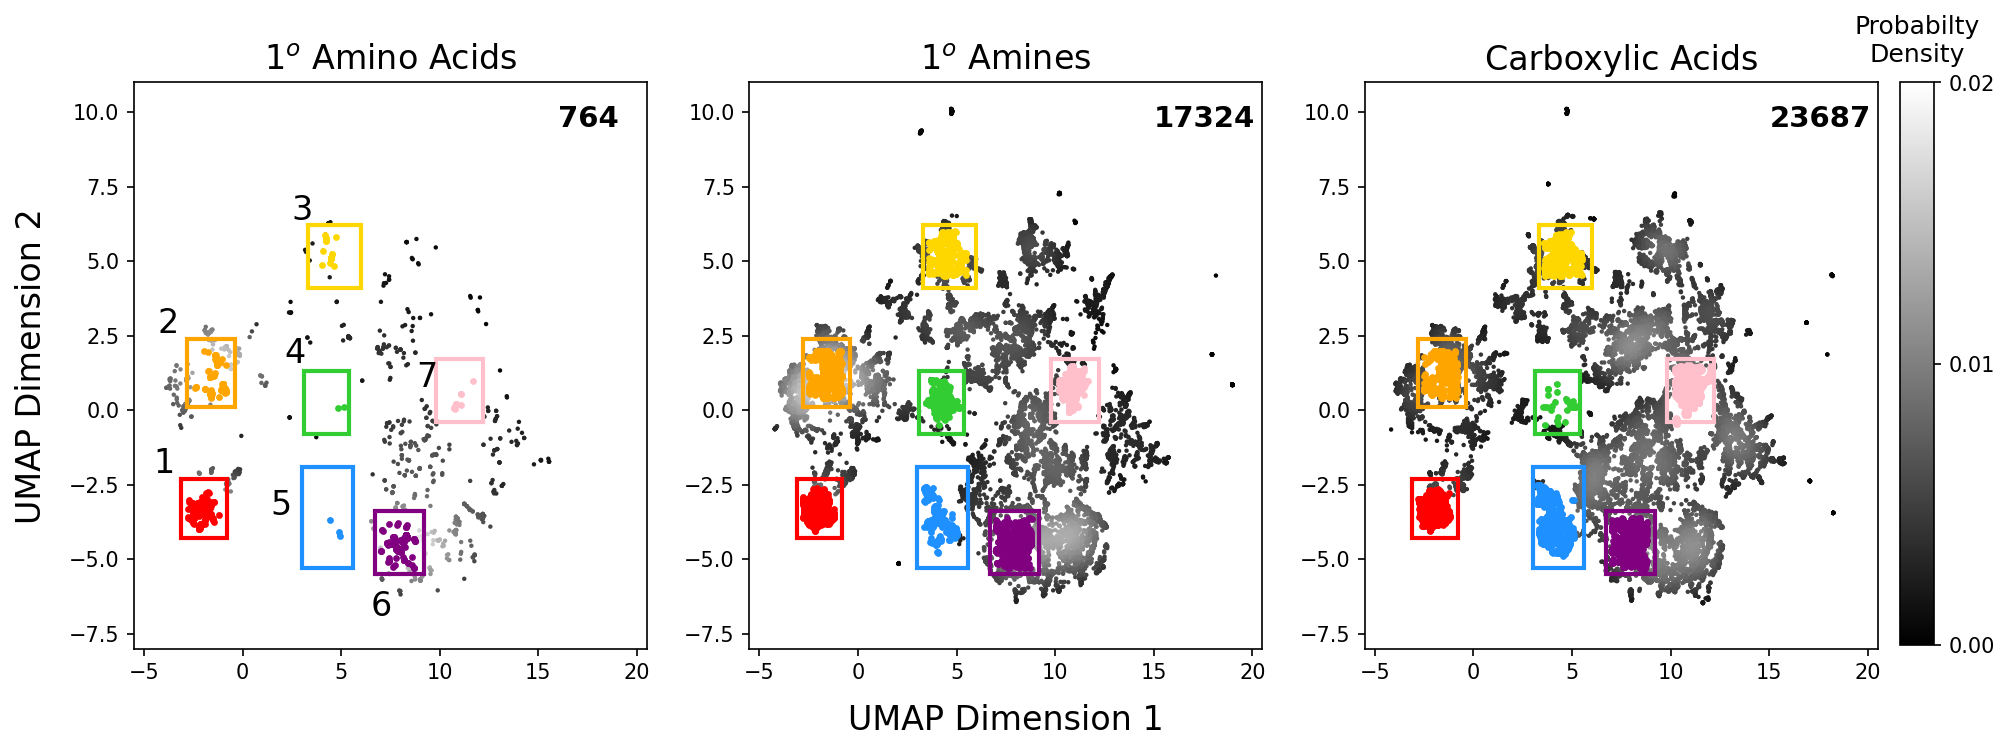

In [31]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=150)
for ax in axs.reshape(-1):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

cmapping='gray'

sc = axs[0].scatter(pAA_umap['X'], pAA_umap['Y'], c=z_pAA, s=5, cmap=cmapping, 
                    marker='.', vmin=t_min, vmax=t_max)
axs[1].scatter(pamine_umap['X'], pamine_umap['Y'], c=z_pamine, s=5, cmap=cmapping, 
               marker='.', vmin=t_min, vmax=t_max)
axs[2].scatter(cooh_umap['X'], cooh_umap['Y'], c=z_cooh, s=5, cmap=cmapping, 
               marker='.', vmin=t_min, vmax=t_max)

axs[0].text(16, 9.5, s=f"{len(set(pAA_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[1].text(15, 9.5, s=f"{len(set(pamine_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')
axs[2].text(15, 9.5, s=f"{len(set(cooh_umap['truncate_SMILES']))}", fontsize=14, fontweight='bold')

axs[1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16)
axs[0].set_ylabel('UMAP Dimension 2', labelpad=10, fontsize=16)

axs[0].scatter(pAA_cluster_1['X'], pAA_cluster_1['Y'], s=5, color='red')
axs[0].scatter(pAA_cluster_2['X'], pAA_cluster_2['Y'], s=5, color='orange')
axs[0].scatter(pAA_cluster_3['X'], pAA_cluster_3['Y'], s=5, color='gold')
axs[0].scatter(pAA_cluster_4['X'], pAA_cluster_4['Y'], s=5, color='limegreen')
axs[0].scatter(pAA_cluster_5['X'], pAA_cluster_5['Y'], s=5, color='dodgerblue')
axs[0].scatter(pAA_cluster_6['X'], pAA_cluster_6['Y'], s=5, color='purple')
axs[0].scatter(pAA_cluster_7['X'], pAA_cluster_7['Y'], s=5, color='pink')
#axs[0].scatter(pAA_cluster_8['X'], pAA_cluster_8['Y'], s=5, color='tan')

axs[1].scatter(pamine_cluster_1['X'], pamine_cluster_1['Y'], s=5, color='red')
axs[1].scatter(pamine_cluster_2['X'], pamine_cluster_2['Y'], s=5, color='orange')
axs[1].scatter(pamine_cluster_3['X'], pamine_cluster_3['Y'], s=5, color='gold')
axs[1].scatter(pamine_cluster_4['X'], pamine_cluster_4['Y'], s=5, color='limegreen')
axs[1].scatter(pamine_cluster_5['X'], pamine_cluster_5['Y'], s=5, color='dodgerblue')
axs[1].scatter(pamine_cluster_6['X'], pamine_cluster_6['Y'], s=5, color='purple')
axs[1].scatter(pamine_cluster_7['X'], pamine_cluster_7['Y'], s=5, color='pink')
#axs[1].scatter(pamine_cluster_8['X'], pamine_cluster_8['Y'], s=5, color='tan')

axs[2].scatter(cooh_cluster_1['X'], cooh_cluster_1['Y'], s=5, color='red')
axs[2].scatter(cooh_cluster_2['X'], cooh_cluster_2['Y'], s=5, color='orange')
axs[2].scatter(cooh_cluster_3['X'], cooh_cluster_3['Y'], s=5, color='gold')
axs[2].scatter(cooh_cluster_4['X'], cooh_cluster_4['Y'], s=5, color='limegreen')
axs[2].scatter(cooh_cluster_5['X'], cooh_cluster_5['Y'], s=5, color='dodgerblue')
axs[2].scatter(cooh_cluster_6['X'], cooh_cluster_6['Y'], s=5, color='purple')
axs[2].scatter(cooh_cluster_7['X'], cooh_cluster_7['Y'], s=5, color='pink')
#axs[2].scatter(cooh_cluster_8['X'], cooh_cluster_8['Y'], s=5, color='tan')

axs[0].set_title("$1^{o}$ Amino Acids", fontsize=16)
axs[1].set_title("$1^{o}$ Amines", fontsize=16)
axs[2].set_title("Carboxylic Acids", fontsize=16)

# Create a Rectangle patch
c1_0 = patches.Rectangle((-3.1, -4.3), 2.3, 2, linewidth=2, edgecolor='red', facecolor='none')
c1_1 = patches.Rectangle((-3.1, -4.3), 2.3, 2, linewidth=2, edgecolor='red', facecolor='none')
c1_2 = patches.Rectangle((-3.1, -4.3), 2.3, 2, linewidth=2, edgecolor='red', facecolor='none')

c2_0 = patches.Rectangle((-2.8, 0.1), 2.4, 2.3, linewidth=2, edgecolor='orange', facecolor='none')
c2_1 = patches.Rectangle((-2.8, 0.1), 2.4, 2.3, linewidth=2, edgecolor='orange', facecolor='none')
c2_2 = patches.Rectangle((-2.8, 0.1), 2.4, 2.3, linewidth=2, edgecolor='orange', facecolor='none')

c3_0 = patches.Rectangle((3.3, 4.1), 2.7, 2.1, linewidth=2, edgecolor='gold', facecolor='none')
c3_1 = patches.Rectangle((3.3, 4.1), 2.7, 2.1, linewidth=2, edgecolor='gold', facecolor='none')
c3_2 = patches.Rectangle((3.3, 4.1), 2.7, 2.1, linewidth=2, edgecolor='gold', facecolor='none')

c4_0 = patches.Rectangle((3.1, -0.8), 2.3, 2.1, linewidth=2, edgecolor='limegreen', facecolor='none')
c4_1 = patches.Rectangle((3.1, -0.8), 2.3, 2.1, linewidth=2, edgecolor='limegreen', facecolor='none')
c4_2 = patches.Rectangle((3.1, -0.8), 2.3, 2.1, linewidth=2, edgecolor='limegreen', facecolor='none')

c5_0 = patches.Rectangle((3, -5.3), 2.6, 3.4, linewidth=2, edgecolor='dodgerblue', facecolor='none')
c5_1 = patches.Rectangle((3, -5.3), 2.6, 3.4, linewidth=2, edgecolor='dodgerblue', facecolor='none')
c5_2 = patches.Rectangle((3, -5.3), 2.6, 3.4, linewidth=2, edgecolor='dodgerblue', facecolor='none')

c6_0 = patches.Rectangle((6.7, -5.5), 2.5, 2.1, linewidth=2, edgecolor='purple', facecolor='none')
c6_1 = patches.Rectangle((6.7, -5.5), 2.5, 2.1, linewidth=2, edgecolor='purple', facecolor='none')
c6_2 = patches.Rectangle((6.7, -5.5), 2.5, 2.1, linewidth=2, edgecolor='purple', facecolor='none')

c7_0 = patches.Rectangle((9.8, -0.4), 2.4, 2.1, linewidth=2, edgecolor='pink', facecolor='none')
c7_1 = patches.Rectangle((9.8, -0.4), 2.4, 2.1, linewidth=2, edgecolor='pink', facecolor='none')
c7_2 = patches.Rectangle((9.8, -0.4), 2.4, 2.1, linewidth=2, edgecolor='pink', facecolor='none')

#c8_0 = patches.Rectangle((12.3, -2.3), 2.7, 2.7, linewidth=2, edgecolor='tan', facecolor='none')
#c8_1 = patches.Rectangle((12.3, -2.3), 2.7, 2.7, linewidth=2, edgecolor='tan', facecolor='none')
#c8_2 = patches.Rectangle((12.3, -2.3), 2.7, 2.7, linewidth=2, edgecolor='tan', facecolor='none')

# Add the patch to the Axes
axs[0].add_patch(c1_0)
axs[1].add_patch(c1_1)
axs[2].add_patch(c1_2)

axs[0].add_patch(c2_0)
axs[1].add_patch(c2_1)
axs[2].add_patch(c2_2)

axs[0].add_patch(c3_0)
axs[1].add_patch(c3_1)
axs[2].add_patch(c3_2)

axs[0].add_patch(c4_0)
axs[1].add_patch(c4_1)
axs[2].add_patch(c4_2)

axs[0].add_patch(c5_0)
axs[1].add_patch(c5_1)
axs[2].add_patch(c5_2)

axs[0].add_patch(c6_0)
axs[1].add_patch(c6_1)
axs[2].add_patch(c6_2)

axs[0].add_patch(c7_0)
axs[1].add_patch(c7_1)
axs[2].add_patch(c7_2)

#axs[0].add_patch(c8_0)
#axs[1].add_patch(c8_1)
#axs[2].add_patch(c8_2)

axs[0].text(-4.5, -2.1, '1', fontsize=16)
axs[0].text(-4.3, 2.6, '2', fontsize=16)
axs[0].text(2.5, 6.4, '3', fontsize=16)
axs[0].text(2.1, 1.6, '4', fontsize=16)
axs[0].text(1.4, -3.5, '5', fontsize=16)
axs[0].text(6.5, -6.9, '6', fontsize=16)
axs[0].text(8.8, 0.8, '7', fontsize=16)
#axs[0].text(14.7, 0.5, '8', fontsize=16)

# axs[1].text(-4.5, -2.1, '1', fontsize=16)
# axs[1].text(-4.3, 2.6, '2', fontsize=16)
# axs[1].text(2.5, 6.4, '3', fontsize=16)
# axs[1].text(2.1, 1.6, '4', fontsize=16)
# axs[1].text(1.4, -3.5, '5', fontsize=16)
# axs[1].text(6.5, -6.9, '6', fontsize=16)
# axs[1].text(8.8, 0.8, '7', fontsize=16)
# #axs[1].text(14.7, 0.5, '8', fontsize=16)

# axs[2].text(-4.5, -2.1, '1', fontsize=16)
# axs[2].text(-4.3, 2.6, '2', fontsize=16)
# axs[2].text(2.5, 6.4, '3', fontsize=16)
# axs[2].text(2.1, 1.6, '4', fontsize=16)
# axs[2].text(1.4, -3.5, '5', fontsize=16)
# axs[2].text(6.5, -6.9, '6', fontsize=16)
# axs[2].text(8.8, 0.8, '7', fontsize=16)
#axs[2].text(14.7, 0.5, '8', fontsize=16)

n_ticks = 3
cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
cbar_ax.set_title("Probabilty\nDensity", pad=10)

cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_ticks(np.linspace(t_min, t_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(t_min, t_max, n_ticks)])

#fig.savefig('figures/figure_2.png')
#fig.savefig('figures/figure_2.svg')
plt.show()

In [32]:
def find_truncates(df, xmin, xmax, ymin, ymax):
    return df.loc[(df['X']>xmin)&(df['X']<xmax)&(df['Y']>ymin)&(df['Y']<ymax)]

def cluster_truncates(pAA, pamine, cooh):
    c_pAA = set(pAA['truncate_SMILES'])
    c_pamine = set(pamine['truncate_SMILES'])
    c_cooh = set(cooh['truncate_SMILES'])
    c = list(c_pAA & c_pamine & c_cooh)
    
    return c

def highlight_truncate(df, truncate):
    m = Chem.MolFromSmiles(df.loc[df['truncate_SMILES'] == truncate, 'BB_SMILES'].iloc[0])
    matches = m.GetSubstructMatches(Chem.MolFromSmiles(truncate))

    tm = rdMolDraw2D.PrepareMolForDrawing(m)
    view = rdMolDraw2D.MolDraw2DSVG(500, 250)
    option = view.drawOptions()

    color = {}
    for index in matches[0]:
        color[index] = (204/256, 255/256, 153/256)

    view.DrawMolecules([tm], highlightAtoms=[matches[0]], highlightAtomColors=[color], highlightBondColors=[color])
    view.FinishDrawing()
    svg = view.GetDrawingText()
    return SVG(svg)

from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image


def highlight_rgroups(df, truncate):
    rgba_color = (204/256, 255/256, 153/256) # light green

    drawer = rdMolDraw2D.MolDraw2DCairo(350, 300)
    drawer.drawOptions().fillHighlights=True
    drawer.drawOptions().setHighlightColour(rgba_color)
    dos = drawer.drawOptions()
    #dos.setBackgroundColour((0,.9,.9,.3))
    #dos.useBWAtomPalette()
    #drawer.drawOptions().multiColourHighlightStyle = MultiColourHighlightStyle.Lasso  
    
    m = Chem.MolFromSmiles(df.loc[df['truncate_SMILES'] == truncate, 'BB_SMILES'].iloc[0])
    atoms = m.GetSubstructMatches(Chem.MolFromSmiles(truncate))[0]

    bonds = []
    for bond in m.GetBonds():
        s = bond.GetBeginAtomIdx()
        f = bond.GetEndAtomIdx()

        if s in atoms and f in atoms:
            bonds.append(bond.GetIdx())

    rdMolDraw2D.PrepareAndDrawMolecule(drawer, m, highlightAtoms=atoms, highlightBonds=bonds) 
    png = drawer.GetDrawingText()
    return png
    
    #bio = io.BytesIO(drawer.GetDrawingText())
    #return Image.open(bio)
    
from PIL import Image as pilImage
from io import BytesIO

def draw_multiple(truncates, dfs, filename, subImageSize=(500,250)):
    nCols = len(truncates)
    nRows = 3
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize, 'WHITE')
    
    for index, trunk in enumerate(truncates):
        for j, df in enumerate(dfs):
            col = index
            row = j 
            png = highlight_rgroups(df, trunk)
            bio = BytesIO(png)
            img = pilImage.open(bio)
            res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
            
    bio = BytesIO()
    res.save(bio, format='PNG')
    res.save(f'{filename}.png')
    return bio.getvalue()

In [33]:
c1_pAA = find_truncates(pAA_umap, c1_xmin, c1_xmax, c1_ymin, c1_ymax)
c1_pamine = find_truncates(pamine_umap, c1_xmin, c1_xmax, c1_ymin, c1_ymax)
c1_cooh = find_truncates(cooh_umap, c1_xmin, c1_xmax, c1_ymin, c1_ymax)

c1_truncates = cluster_truncates(c1_pAA, c1_pamine, c1_cooh)
print(len(c1_truncates))

78


In [34]:
from IPython.display import SVG,Image

c1_list = [c1_pAA, c1_pamine, c1_cooh]
#Image(draw_multiple(c1_truncates[:3], c1_list, 'SI_figures/c1_truncates'))

In [35]:
c2_pAA = find_truncates(pAA_umap, c2_xmin, c2_xmax, c2_ymin, c2_ymax)
c2_pamine = find_truncates(pamine_umap, c2_xmin, c2_xmax, c2_ymin, c2_ymax)
c2_cooh = find_truncates(cooh_umap, c2_xmin, c2_xmax, c2_ymin, c2_ymax)

c2_truncates = cluster_truncates(c2_pAA, c2_pamine, c2_cooh)
print(len(c2_truncates))

49


In [36]:
from IPython.display import SVG,Image

c2_list = [c2_pAA, c2_pamine, c2_cooh]
#Image(draw_multiple(c2_truncates[:3], c2_list, 'SI_figures/c2_truncates'))

In [37]:
c3_pAA = find_truncates(pAA_umap, c3_xmin, c3_xmax, c3_ymin, c3_ymax)
c3_pamine = find_truncates(pamine_umap, c3_xmin, c3_xmax, c3_ymin, c3_ymax)
c3_cooh = find_truncates(cooh_umap, c3_xmin, c3_xmax, c3_ymin, c3_ymax)

c3_truncates = cluster_truncates(c3_pAA, c3_pamine, c3_cooh)
print(len(c3_truncates))

8


In [38]:
from IPython.display import SVG,Image

c3_list = [c3_pAA, c3_pamine, c3_cooh]
#Image(draw_multiple(c3_truncates[:3], c3_list, 'SI_figures/c3_truncates'))

In [39]:
c4_pAA = find_truncates(pAA_umap, c4_xmin, c4_xmax, c4_ymin, c4_ymax)
c4_pamine = find_truncates(pamine_umap, c4_xmin, c4_xmax, c4_ymin, c4_ymax)
c4_cooh = find_truncates(cooh_umap, c4_xmin, c4_xmax, c4_ymin, c4_ymax)

c4_truncates = cluster_truncates(c4_pAA, c4_pamine, c4_cooh)
print(len(c4_truncates))

1


In [40]:
from IPython.display import SVG,Image

c4_list = [c4_pAA, c4_pamine, c4_cooh]
#Image(draw_multiple(c4_truncates, c4_list, 'SI_figures/c4_truncates'))

In [41]:
c5_pAA = find_truncates(pAA_umap, c5_xmin, c5_xmax, c5_ymin, c5_ymax)
c5_pamine = find_truncates(pamine_umap, c5_xmin, c5_xmax, c5_ymin, c5_ymax)
c5_cooh = find_truncates(cooh_umap, c5_xmin, c5_xmax, c5_ymin, c5_ymax)

c5_truncates = cluster_truncates(c5_pAA, c5_pamine, c5_cooh)
print(len(c5_truncates))

1


In [42]:
from IPython.display import SVG,Image

c5_list = [c5_pAA, c5_pamine, c5_cooh]
#Image(draw_multiple(c5_truncates, c5_list, 'SI_figures/c5_truncates'))

In [43]:
c6_pAA = find_truncates(pAA_umap, c6_xmin, c6_xmax, c6_ymin, c6_ymax)
c6_pamine = find_truncates(pamine_umap, c6_xmin, c6_xmax, c6_ymin, c6_ymax)
c6_cooh = find_truncates(cooh_umap, c6_xmin, c6_xmax, c6_ymin, c6_ymax)

c6_truncates = cluster_truncates(c6_pAA, c6_pamine, c6_cooh)
print(len(c6_truncates))

53


In [44]:
from IPython.display import SVG,Image

c6_list = [c6_pAA, c6_pamine, c6_cooh]
#Image(draw_multiple(c6_truncates[3:6], c6_list, 'SI_figures/c6_truncates'))

In [45]:
c7_pAA = find_truncates(pAA_umap, c7_xmin, c7_xmax, c7_ymin, c7_ymax)
c7_pamine = find_truncates(pamine_umap, c7_xmin, c7_xmax, c7_ymin, c7_ymax)
c7_cooh = find_truncates(cooh_umap, c7_xmin, c7_xmax, c7_ymin, c7_ymax)

c7_truncates = cluster_truncates(c7_pAA, c7_pamine, c7_cooh)
print(len(c7_truncates))

4


In [50]:
from IPython.display import SVG,Image

c7_list = [c7_pAA, c7_pamine, c7_cooh]
#Image(draw_multiple(c7_truncates[:3], c7_list, 'SI_figures/c7_truncates'))

In [47]:
c8_pAA = find_truncates(pAA_umap, c8_xmin, c8_xmax, c8_ymin, c8_ymax)
c8_pamine = find_truncates(pamine_umap, c8_xmin, c8_xmax, c8_ymin, c8_ymax)
c8_cooh = find_truncates(cooh_umap, c8_xmin, c8_xmax, c8_ymin, c8_ymax)

c8_truncates = cluster_truncates(c8_pAA, c8_pamine, c8_cooh)
print(len(c8_truncates))

9


In [48]:
from IPython.display import SVG,Image

c8_list = [c8_pAA, c8_pamine, c8_cooh]
#Image(draw_multiple(c8_truncates[:3], c8_list, 'SI_figures/c8_truncates'))

In [31]:
# m = 4
# c1_pAA_truncate = highlight_truncate(c1_pAA, c1_truncates[m])
# c1_pamine_truncate = highlight_truncate(c1_pamine, c1_truncates[m])
# c1_cooh_truncate = highlight_truncate(c1_cooh, c1_truncates[m])
# display(c1_pAA_truncate)
# display(c1_pamine_truncate)
# display(c1_cooh_truncate)

In [32]:
# from matplotlib.colors import ColorConverter
# from IPython.display import SVG, display

# N = 1

# m = Chem.MolFromSmiles(c1_pAA.loc[c1_pAA['truncate_SMILES'] == c1_truncates[N], 'BB_SMILES'].iloc[0])
# matches = m.GetSubstructMatches(Chem.MolFromSmiles(c1_truncates[N]))

# tm = rdMolDraw2D.PrepareMolForDrawing(m)
# view = rdMolDraw2D.MolDraw2DSVG(500, 250)
# option = view.drawOptions()

# color = {}
# for index in matches[0]:
#     color[index] = (204/256, 255/256, 153/256)

# view.DrawMolecules([tm], highlightAtoms=[matches[0]], highlightAtomColors=[color], highlightBondColors=[color])
# view.FinishDrawing()
# svg = view.GetDrawingText()
# display(SVG(svg))

### Figure 3: UMAP projections and kernel density estimates

In [51]:
z_pamine = kde_estimate(pamine_umap)
z_pAA = kde_estimate(pAA_umap)
z_cooh = kde_estimate(cooh_umap)

#### Visualize subsets

In [34]:
# ss_A = df.loc[(df['X'] < -2) & (df['Y'] < 11) & (df['Y'] > 9)]
# ss_B = df.loc[(df['X'] < -1) & (df['X'] > -2.5) & (df['Y'] < 6) & (df['Y'] > 4)]
# ss_C = df.loc[(df['X'] < 10) & (df['X'] > 8) & (df['Y'] < 11) & (df['Y'] > 9)]
# ss_D = df.loc[(df['X'] < 9) & (df['X'] > 7) & (df['Y'] < 5.5) & (df['Y'] > 3.5)]

# plt.figure(figsize=(10,10))


# plt.scatter(df['X'], df['Y'], marker='.', alpha=0.1)
# #plt.scatter(ss_A['X'], ss_A['Y'], marker='.', alpha=0.5, color='red')
# #plt.scatter(ss_B['X'], ss_B['Y'], marker='.', alpha=0.5, color='orange')
# #plt.scatter(ss_C['X'], ss_C['Y'], marker='.', alpha=0.5, color='yellow')
# plt.scatter(ss_D['X'], ss_D['Y'], marker='.', alpha=0.5, color='purple')

In [35]:
# ss_A_sub = ss_A.sample(n=9, random_state=1)
# ss_A_mol = [Chem.MolFromSmiles(smi) for smi in ss_A_sub['truncate_SMILES']]
# #Chem.Draw.MolsToGridImage(ss_A_mol, molsPerRow=3)

# ss_B_sub = ss_B.sample(n=9, random_state=0)
# ss_B_mol = [Chem.MolFromSmiles(smi) for smi in ss_B_sub['truncate_SMILES']]
# #Chem.Draw.MolsToGridImage(ss_B_mol, molsPerRow=3)

# ss_C_sub = ss_C.sample(n=9, random_state=0)
# ss_C_mol = [Chem.MolFromSmiles(smi) for smi in ss_C_sub['truncate_SMILES']]
# #Chem.Draw.MolsToGridImage(ss_C_mol, molsPerRow=3)

# ss_D_sub = ss_D.sample(n=9, random_state=0)
# ss_D_mol = [Chem.MolFromSmiles(smi) for smi in ss_D_sub['truncate_SMILES']]
# #Chem.Draw.MolsToGridImage(ss_D_mol, molsPerRow=3)

### Figure 3: Building block cost filtering 

In [52]:
pamine_100 = pamine_umap.loc[pamine_umap['Price_250mg'] <= 100].drop_duplicates(subset='truncate_SMILES')
pamine_250 = pamine_umap.loc[pamine_umap['Price_250mg'] <= 250].drop_duplicates(subset='truncate_SMILES')
pamine_500 = pamine_umap.loc[pamine_umap['Price_250mg'] <= 500].drop_duplicates(subset='truncate_SMILES')

pAA_100 = pAA_umap.loc[pAA_umap['Price_250mg'] <= 100].drop_duplicates(subset='truncate_SMILES')
pAA_250 = pAA_umap.loc[pAA_umap['Price_250mg'] <= 250].drop_duplicates(subset='truncate_SMILES')
pAA_500 = pAA_umap.loc[pAA_umap['Price_250mg'] <= 500].drop_duplicates(subset='truncate_SMILES')

cooh_100 = cooh_umap.loc[cooh_umap['Price_250mg'] <= 100].drop_duplicates(subset='truncate_SMILES')
cooh_250 = cooh_umap.loc[cooh_umap['Price_250mg'] <= 250].drop_duplicates(subset='truncate_SMILES')
cooh_500 = cooh_umap.loc[cooh_umap['Price_250mg'] <= 500].drop_duplicates(subset='truncate_SMILES')

In [53]:
z_pamine_100 = kde_estimate(pamine_100)
z_pamine_250 = kde_estimate(pamine_250)
z_pamine_500 = kde_estimate(pamine_500)

z_pAA_100 = kde_estimate(pAA_100)
z_pAA_250 = kde_estimate(pAA_250)
z_pAA_500 = kde_estimate(pAA_500)

z_cooh_100 = kde_estimate(cooh_100)
z_cooh_250 = kde_estimate(cooh_250)
z_cooh_500 = kde_estimate(cooh_500)

In [54]:
cost_z_min = np.min([np.min(z_cooh_100), np.min(z_pAA_100), np.min(z_pamine_100),
          np.min(z_cooh_250), np.min(z_pAA_250), np.min(z_pamine_250),
          np.min(z_cooh_500), np.min(z_pAA_500), np.min(z_pamine_500)])

cost_z_max = np.max([np.max(z_cooh_100), np.max(z_pAA_100), np.max(z_pamine_100),
           np.max(z_cooh_250), np.max(z_pAA_250), np.max(z_pamine_250),
           np.max(z_cooh_500), np.max(z_pAA_500), np.max(z_pamine_500)])

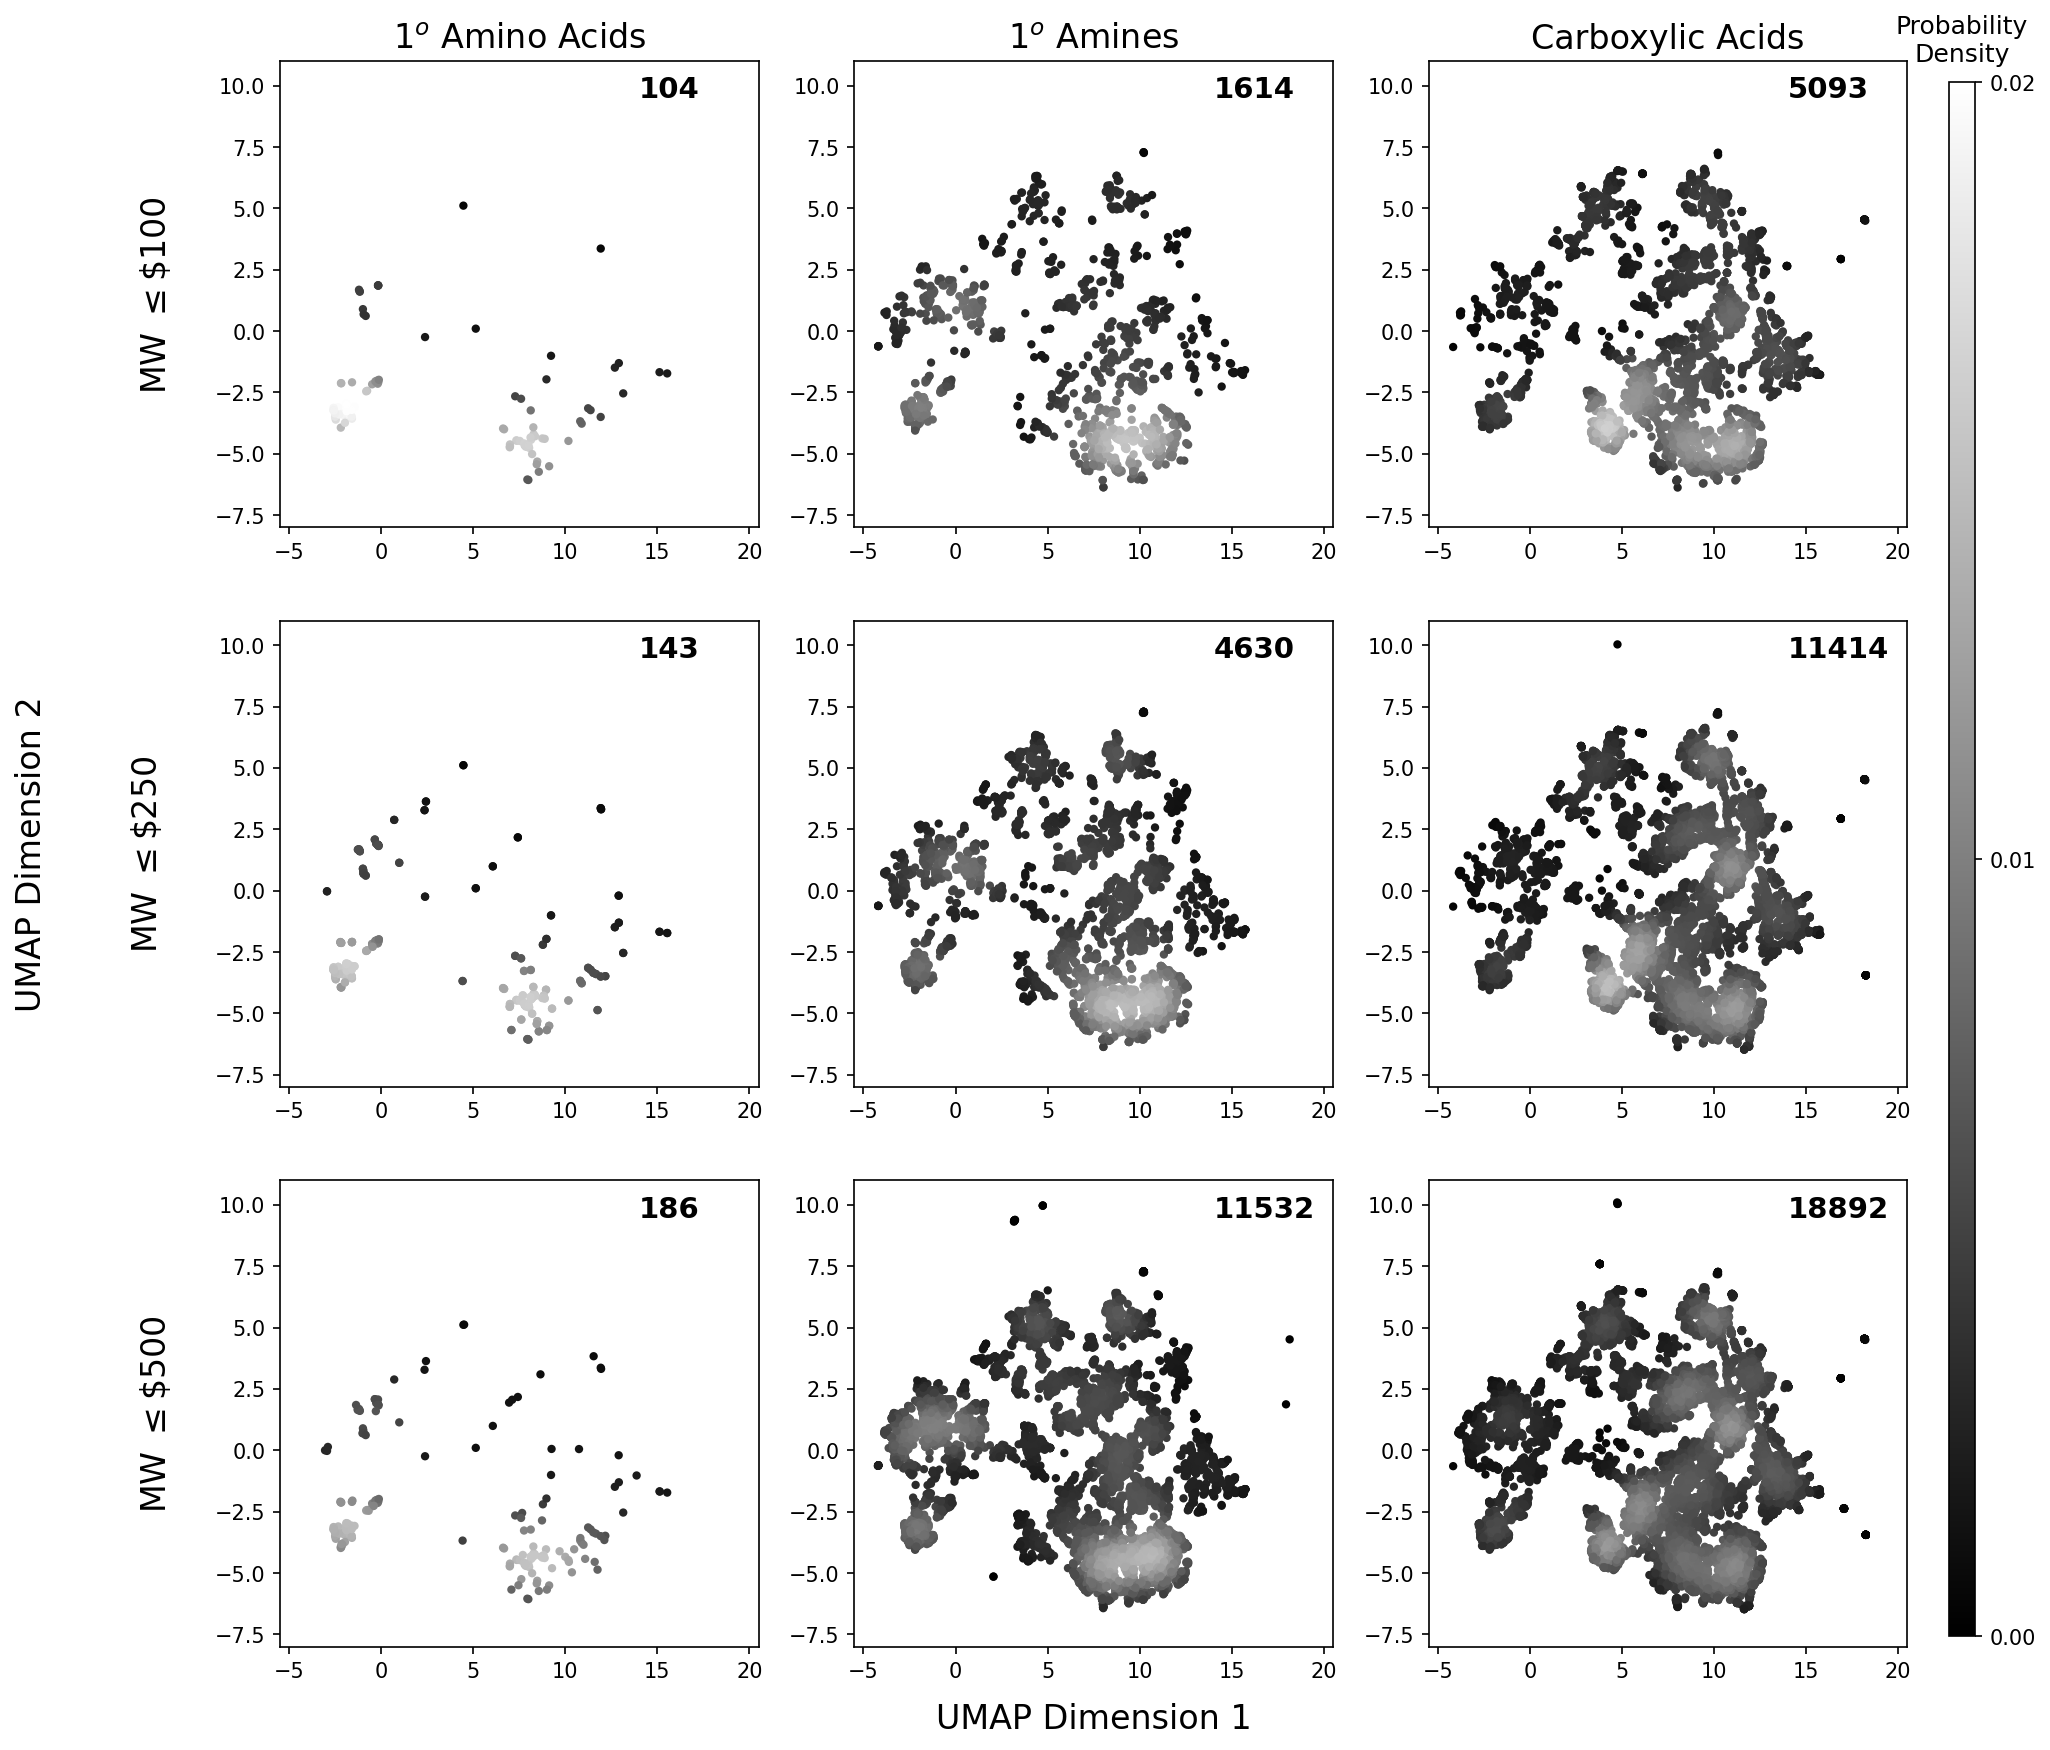

In [61]:
fig, axs = plt.subplots(3, 3, figsize=(14,14), dpi=150)
cost_list = [pAA_100, pamine_100, cooh_100,
             pAA_250, pamine_250, cooh_250,
             pAA_500, pamine_500, cooh_500]

z_list = [z_pAA_100, z_pamine_100, z_cooh_100,
          z_pAA_250, z_pamine_250, z_cooh_250,
          z_pAA_500, z_pamine_500, z_cooh_500]


for index, ax in enumerate(axs.reshape(-1)):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(cost_list[index]['X'], cost_list[index]['Y'], c=z_list[index],
               cmap='gray', marker='.', vmin=cost_z_min, vmax=cost_z_max)
    ax.text(14, 9.5, f"{len(set(cost_list[index]['truncate_SMILES']))}", fontweight='bold', fontsize=14)
    
sc1 = axs[1][0].scatter(pAA_250['X'], pAA_250['Y'], c=z_pAA_250, cmap='gray', marker='.',
                       vmin=cost_z_min, vmax=cost_z_max)
    
axs[0][0].set_title('$1^{o}$ Amino Acids', fontsize=16)
axs[0][1].set_title('$1^{o}$ Amines', fontsize=16)
axs[0][2].set_title('Carboxylic Acids', fontsize=16)

axs[0][0].set_ylabel('MW $\leq \$100$', rotation=90, labelpad=20, fontsize=16)
axs[1][0].set_ylabel('UMAP Dimension 2', labelpad=80, fontsize=16)
axs[1][1].set_ylabel('MW $\leq \$250$', rotation=90, labelpad=300, fontsize=16)

axs[2][0].set_ylabel('MW $\leq \$500$', rotation=90, labelpad=20, fontsize=16)
axs[2][1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16)

n_ticks = 3
cbar_ax = fig.add_axes([0.92, 0.13, 0.012, 0.74])
cbar_ax.set_title("Probability\nDensity", pad=10)
cbar = plt.colorbar(sc1, cax=cbar_ax)
cbar.set_ticks(np.linspace(cost_z_min, cost_z_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(cost_z_min, cost_z_max, n_ticks)])

#fig.savefig('figures/figure_3.png')
#fig.savefig('figures/figure_3.svg')
plt.show()

#### Cost <$100

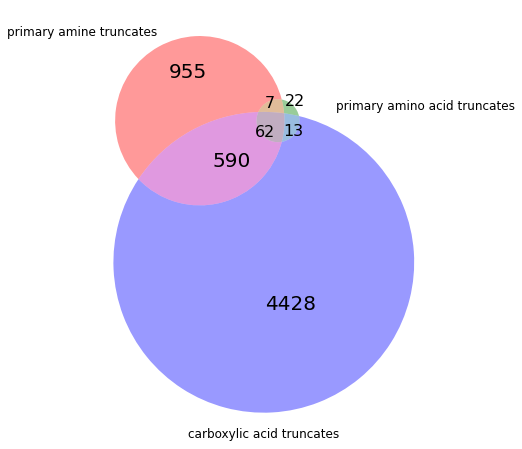

In [62]:
from matplotlib_venn import venn2, venn3

# A: 100, B: 010, C: 110, D: 001, E: 101, F: 011, G: 111
# venn3(subsets=(1,2,3,4,5,6,7))

pAA_truncates = set(pAA_100['truncate_SMILES'])
pamine_truncates = set(pamine_100['truncate_SMILES'])
cooh_truncates = set(cooh_100['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.16, 0.43))
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[6].set_fontsize(16)

#fig.savefig('figures/cost_100_venn.png')
#fig.savefig('figures/cost_100_venn.svg')

#### Cost <$250

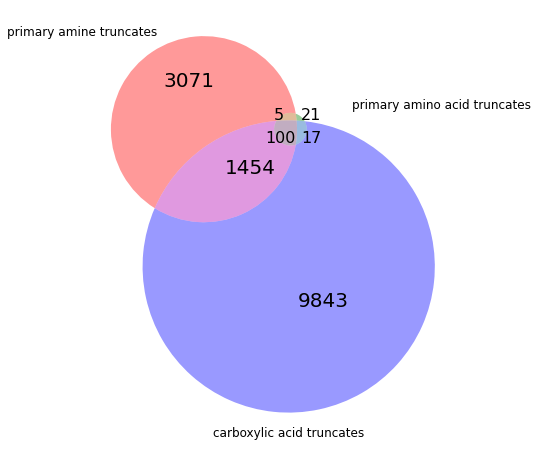

In [66]:
pAA_truncates = set(pAA_250['truncate_SMILES'])
pamine_truncates = set(pamine_250['truncate_SMILES'])
cooh_truncates = set(cooh_250['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.16, 0.38)) # green
v3_s.subset_labels[2].set_position((0.05, 0.38)) # yellow
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[5].set_position((0.16, 0.30)) # turquoise
v3_s.subset_labels[6].set_fontsize(16)

#fig.savefig('figures/cost_250_venn.png')
#fig.savefig('figures/cost_250_venn.svg')

#### Cost <$500

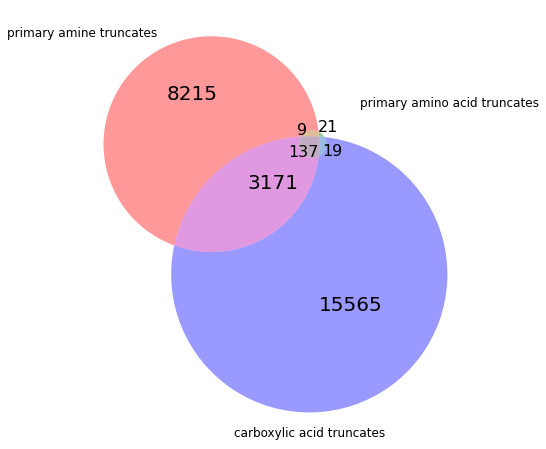

In [65]:
pAA_truncates = set(pAA_500['truncate_SMILES'])
pamine_truncates = set(pamine_500['truncate_SMILES'])
cooh_truncates = set(cooh_500['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.19, 0.33)) # green
v3_s.subset_labels[2].set_position((0.1, 0.32)) # yellow
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[5].set_position((0.205, 0.25)) # turquoise
v3_s.subset_labels[6].set_fontsize(16)

#fig.savefig('figures/cost_500_venn.png')
#fig.savefig('figures/cost_500_venn.svg')

#### No cost filter

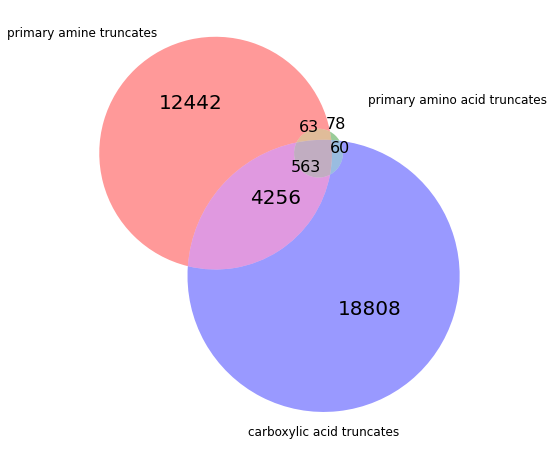

In [86]:
pAA_truncates = set(pAA_umap['truncate_SMILES'])
pamine_truncates = set(pamine_umap['truncate_SMILES'])
cooh_truncates = set(cooh_umap['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.19, 0.33)) # green
v3_s.subset_labels[2].set_position((0.1, 0.32)) # yellow
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[5].set_position((0.205, 0.25)) # turquoise
v3_s.subset_labels[6].set_fontsize(16)

#fig.savefig('figures/no_cost_venn.png')
#fig.savefig('figures/no_cost_venn.svg')

In [87]:
cost_val = np.zeros((4,3))
cost_val[0][0] = len(set(pAA_100['truncate_SMILES']))
cost_val[0][1] = len(set(pamine_100['truncate_SMILES']))
cost_val[0][2] = len(set(cooh_100['truncate_SMILES']))

cost_val[1][0] = len(set(pAA_250['truncate_SMILES']))
cost_val[1][1] = len(set(pamine_250['truncate_SMILES']))
cost_val[1][2] = len(set(cooh_250['truncate_SMILES']))

cost_val[2][0] = len(set(pAA_500['truncate_SMILES']))
cost_val[2][1] = len(set(pamine_500['truncate_SMILES']))
cost_val[2][2] = len(set(cooh_500['truncate_SMILES']))

cost_val[3][0] = len(set(pAA_umap['truncate_SMILES']))
cost_val[3][1] = len(set(pamine_umap['truncate_SMILES']))
cost_val[3][2] = len(set(cooh_umap['truncate_SMILES']))

array_to_latex.to_ltx(cost_val, frmt='{:n}', arraytype='tabular')

\begin{tabular}
  104  &  1614  &  5093 \\
  143  &  4630  &  11414 \\
  186  &  11532  &  18892 \\
  764  &  17324  &  23687 
\end{tabular}


### Figure 4: PCP filtering for building blocks (not the truncates)

In [90]:
def make_molecules(smiles):
    molecules = []
    for iso_smi in smiles:
        mol = oechem.OEMol()
        oechem.OESmilesToMol(mol, iso_smi)
        molecules.append(mol)
    return molecules

In [92]:
def has_pg(compound_SMILES, pg):
    '''
    Returns True if the SMILES string contains the protecting group of interest
    '''
    ss = oechem.OESubSearch(pg)
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, compound_SMILES)
    oechem.OEPrepareSearch(mol, ss)
    return ss.SingleMatch(mol)

pg_dict = pickle.load(open('../files/PG_SMILES.pkl', 'rb'))

def deprotectGroup(compound_smi, pg_SMIRKS):
    '''
    Returns the SMILES of the deprotected compound after SMIRKS reaction. If the protecting group is not present
    in the compound, the input SMILES is returned.
    '''
    libgen = oechem.OELibraryGen(pg_SMIRKS)
    libgen.SetValenceCorrection(True)

    ## Rewrite the SMILES to remove kekulization for Fmoc specifically
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, compound_smi)
    rewrite_smi = oechem.OECreateIsoSmiString(mol)

    new_mol = oechem.OEGraphMol()
    oechem.OEParseSmiles(new_mol, rewrite_smi)
    libgen.SetStartingMaterial(new_mol, 0)

    if libgen.NumPossibleProducts() > 0:
        for product in libgen.GetProducts():
            new_smi = oechem.OECreateIsoSmiString(product)

        ## If a different pattern than expected got caught by the query and split
        ## we would prefer to just leave that compound as is
        if '.' in new_smi:
            return rewrite_smi
        else:
            return new_smi

pg_smirks = pickle.load(open('../files/deprot_SMIRKS.pkl', 'rb'))

#### Primary amines

In [93]:
## Need to adjust MW calcs for BBs containing protecting groups
pamine_umap['fmoc'] = pamine_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
pamine_umap['nboc'] = pamine_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [94]:
print(len(pamine_umap))
print(len(pamine_umap.loc[pamine_umap['fmoc'] == True]))
print(len(pamine_umap.loc[pamine_umap['nboc'] == True]))

21109
0
0


In [95]:
pamine_mols = make_molecules(pamine_umap['BB_SMILES'])
pamine_umap['molecules'] = pamine_mols
pamine_umap['mw'] = pamine_umap['molecules'].apply(oechem.OECalculateMolecularWeight)
pamine_umap['tpsa'] = pamine_umap['molecules'].apply(oemolprop.OEGet2dPSA)
pamine_umap['hbd'] = pamine_umap['molecules'].apply(oemolprop.OEGetHBondDonorCount)
pamine_umap['hba'] = pamine_umap['molecules'].apply(oemolprop.OEGetHBondAcceptorCount)

pamine_xlogp = np.ones(len(pamine_umap)) * 100
for i in range(len(pamine_umap)):
    mol = pamine_umap['molecules'].iloc[i]
    try:
        pamine_xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
pamine_umap['xlogp'] = pamine_xlogp

#### Primary amino acids

In [96]:
## Need to adjust MW calcs for BBs containing protecting groups
pAA_umap['fmoc'] = pAA_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
pAA_umap['nboc'] = pAA_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [97]:
print(len(pAA_umap))
print(len(pAA_umap.loc[pAA_umap['fmoc'] == True]))
print(len(pAA_umap.loc[pAA_umap['nboc'] == True]))

1396
1396
0


In [98]:
pAA_umap['deprot_smi'] = pAA_umap['BB_SMILES'].apply(lambda smi: deprotectGroup(smi, pg_smirks['fmoc']))

In [99]:
pAA_mols = make_molecules(pAA_umap['deprot_smi'])
pAA_umap['molecules'] = pAA_mols
pAA_umap['mw'] = pAA_umap['molecules'].apply(oechem.OECalculateMolecularWeight)
pAA_umap['tpsa'] = pAA_umap['molecules'].apply(oemolprop.OEGet2dPSA)
pAA_umap['hbd'] = pAA_umap['molecules'].apply(oemolprop.OEGetHBondDonorCount)
pAA_umap['hba'] = pAA_umap['molecules'].apply(oemolprop.OEGetHBondAcceptorCount)

pAA_xlogp = np.ones(len(pAA_umap)) * 100
for i in range(len(pAA_umap)):
    mol = pAA_umap['molecules'].iloc[i]
    try:
        pAA_xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
pAA_umap['xlogp'] = pAA_xlogp

#### Carboxylic acids

In [100]:
## Need to adjust MW calcs for BBs containing protecting groups
cooh_umap['fmoc'] = cooh_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['fmoc']))
cooh_umap['nboc'] = cooh_umap['BB_SMILES'].apply(lambda smi: has_pg(smi, pg_dict['nboc']))

In [101]:
print(len(cooh_umap))
print(len(cooh_umap.loc[cooh_umap['fmoc'] == True]))
print(len(cooh_umap.loc[cooh_umap['nboc'] == True]))

31091
0
0


In [102]:
cooh_mols = make_molecules(cooh_umap['BB_SMILES'])
cooh_umap['molecules'] = cooh_mols
cooh_umap['mw'] = cooh_umap['molecules'].apply(oechem.OECalculateMolecularWeight)
cooh_umap['tpsa'] = cooh_umap['molecules'].apply(oemolprop.OEGet2dPSA)
cooh_umap['hbd'] = cooh_umap['molecules'].apply(oemolprop.OEGetHBondDonorCount)
cooh_umap['hba'] = cooh_umap['molecules'].apply(oemolprop.OEGetHBondAcceptorCount)

cooh_xlogp = np.ones(len(cooh_umap)) * 100
for i in range(len(cooh_umap)):
    mol = cooh_umap['molecules'].iloc[i]
    try:
        cooh_xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
cooh_umap['xlogp'] = cooh_xlogp

In [103]:
## Implement MW filters (MW: <=200, <=250, <=300)

pamine_mw200 = pamine_umap.loc[pamine_umap['mw'] <= 200].drop_duplicates(subset='truncate_SMILES')
pamine_mw250 = pamine_umap.loc[pamine_umap['mw'] <= 250].drop_duplicates(subset='truncate_SMILES')
pamine_mw300 = pamine_umap.loc[pamine_umap['mw'] <= 300].drop_duplicates(subset='truncate_SMILES')

pAA_mw200 = pAA_umap.loc[pAA_umap['mw'] <= 200].drop_duplicates(subset='truncate_SMILES')
pAA_mw250 = pAA_umap.loc[pAA_umap['mw'] <= 250].drop_duplicates(subset='truncate_SMILES')
pAA_mw300 = pAA_umap.loc[pAA_umap['mw'] <= 300].drop_duplicates(subset='truncate_SMILES')

cooh_mw200 = cooh_umap.loc[cooh_umap['mw'] <= 200].drop_duplicates(subset='truncate_SMILES')
cooh_mw250 = cooh_umap.loc[cooh_umap['mw'] <= 250].drop_duplicates(subset='truncate_SMILES')
cooh_mw300 = cooh_umap.loc[cooh_umap['mw'] <= 300].drop_duplicates(subset='truncate_SMILES')

In [104]:
z_pamine_mw200 = kde_estimate(pamine_mw200)
z_pamine_mw250 = kde_estimate(pamine_mw250)
z_pamine_mw300 = kde_estimate(pamine_mw300)

z_pAA_mw200 = kde_estimate(pAA_mw200)
z_pAA_mw250 = kde_estimate(pAA_mw250)
z_pAA_mw300 = kde_estimate(pAA_mw300)

z_cooh_mw200 = kde_estimate(cooh_mw200)
z_cooh_mw250 = kde_estimate(cooh_mw250)
z_cooh_mw300 = kde_estimate(cooh_mw300)

In [105]:
z_mw_min = np.min([np.min(z_cooh_mw200), np.min(z_pAA_mw200), np.min(z_pamine_mw200),
          np.min(z_cooh_mw250), np.min(z_pAA_mw250), np.min(z_pamine_mw250),
          np.min(z_cooh_mw300), np.min(z_pAA_mw300), np.min(z_pamine_mw300)])

z_mw_max = np.max([np.max(z_cooh_mw200), np.max(z_pAA_mw200), np.max(z_pamine_mw200),
           np.max(z_cooh_mw250), np.max(z_pAA_mw250), np.max(z_pamine_mw250),
           np.max(z_cooh_mw300), np.max(z_pAA_mw300), np.max(z_pamine_mw300)])

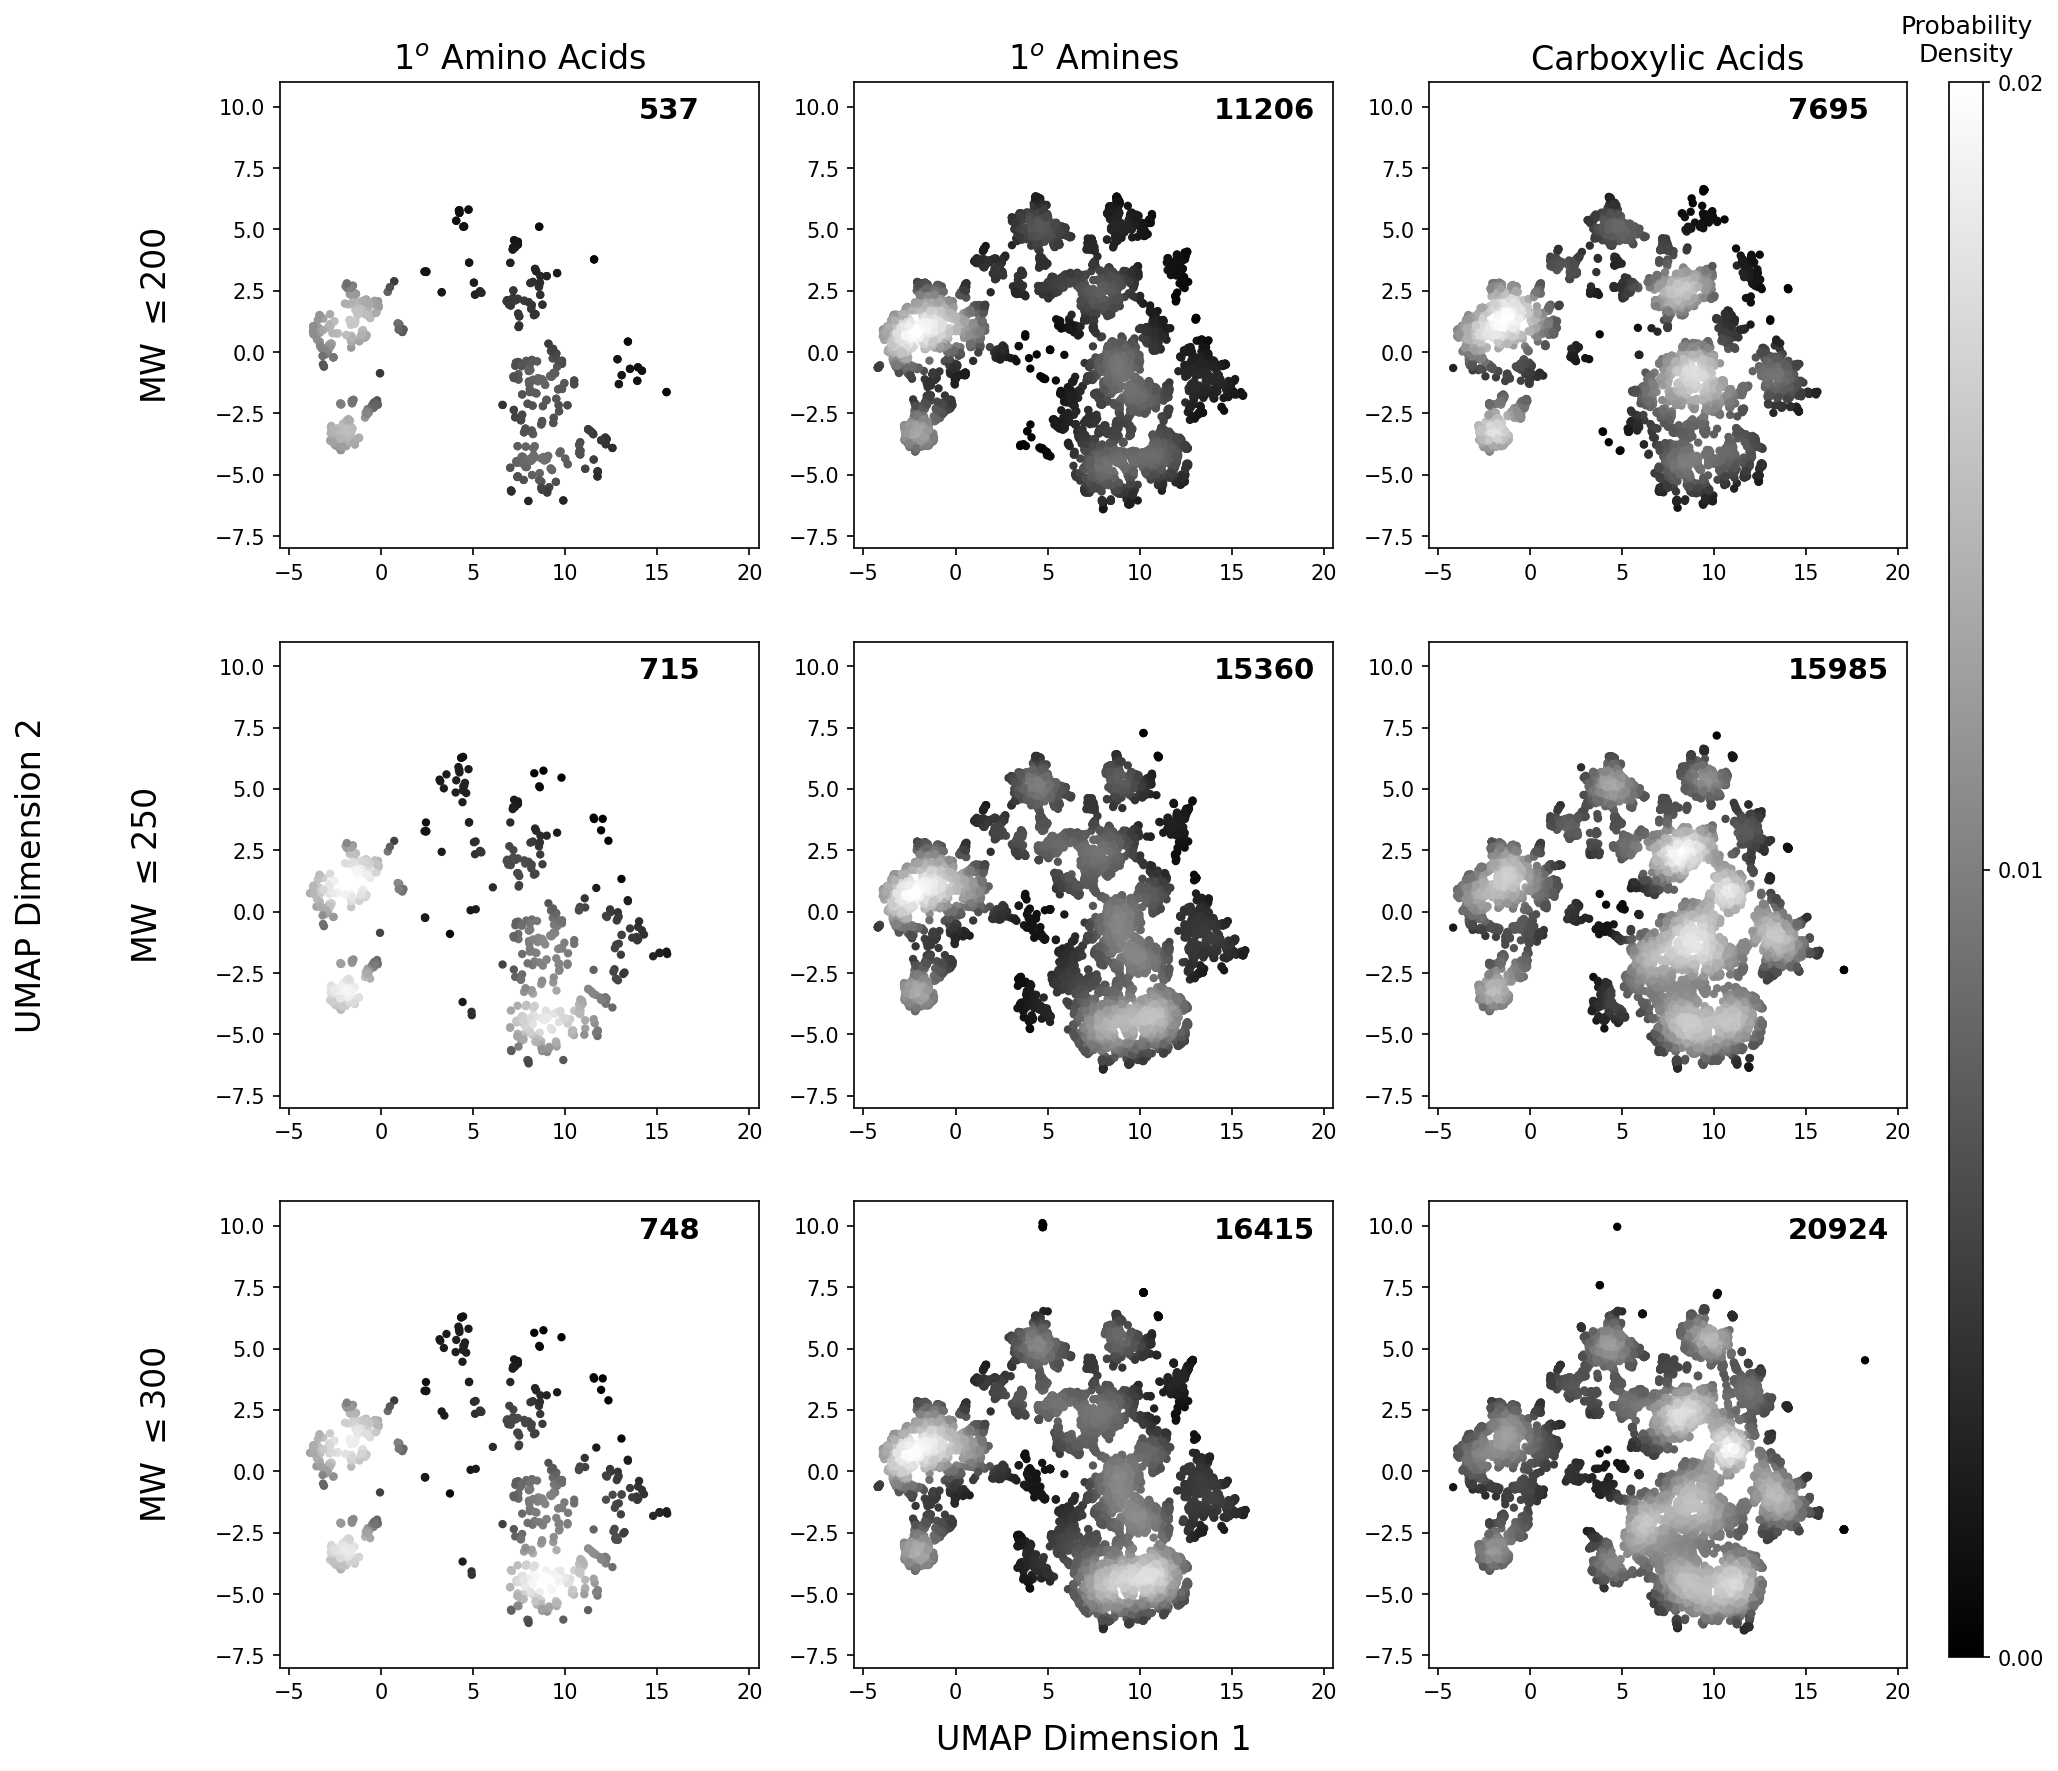

In [107]:
fig, axs = plt.subplots(3, 3, figsize=(14,14), dpi=150)
mw_list = [pAA_mw200, pamine_mw200, cooh_mw200,
           pAA_mw250, pamine_mw250, cooh_mw250,
           pAA_mw300, pamine_mw300, cooh_mw300]

z_list = [z_pAA_mw200, z_pamine_mw200, z_cooh_mw200,
          z_pAA_mw250, z_pamine_mw250, z_cooh_mw250,
          z_pAA_mw300, z_pamine_mw300, z_cooh_mw300]

for index, ax in enumerate(axs.reshape(-1)):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(mw_list[index]['X'], mw_list[index]['Y'], c=z_list[index],
               cmap='gray', marker='.')
    ax.text(14, 9.5, f"{len(set(mw_list[index]['truncate_SMILES']))}", fontsize=14, fontweight='bold')
    
sc0 = axs[0][0].scatter(pAA_mw200['X'], pAA_mw200['Y'], c=z_pAA_mw200, cmap='gray', marker='.',
                       vmin=z_mw_min, vmax=z_mw_max)

# axs[0][0].set_title('$1^{o}$ Amino Acids', fontsize=16)
# axs[0][1].set_title('$1^{o}$ Amines', fontsize=16)
# axs[0][2].set_title('Carboxylic Acids', fontsize=16)

# axs[1][0].set_ylabel('UMAP Dimension 2', fontsize=16)
# axs[2][1].set_xlabel('UMAP Dimension 1', fontsize=16)

axs[0][0].set_title('$1^{o}$ Amino Acids', fontsize=16)
axs[0][1].set_title('$1^{o}$ Amines', fontsize=16)
axs[0][2].set_title('Carboxylic Acids', fontsize=16)

axs[0][0].set_ylabel('MW $\leq 200$', rotation=90, labelpad=20, fontsize=16)
axs[1][0].set_ylabel('UMAP Dimension 2', labelpad=80, fontsize=16)
axs[1][1].set_ylabel('MW $\leq 250$', rotation=90, labelpad=300, fontsize=16)

axs[2][0].set_ylabel('MW $\leq 300$', rotation=90, labelpad=20, fontsize=16)
axs[2][1].set_xlabel('UMAP Dimension 1', labelpad=10, fontsize=16)

n_ticks = 3
cbar_ax1 = fig.add_axes([0.92, 0.13, 0.016, 0.75])
cbar_ax1.set_title('Probability\nDensity', pad=10)
cbar = plt.colorbar(sc0, cax=cbar_ax1)
cbar.set_ticks(np.linspace(z_mw_min, z_mw_max, n_ticks))
cbar.set_ticklabels([f"{x:.2f}" for x in np.linspace(z_mw_min, z_mw_max, n_ticks)])

#fig.savefig('figures/figure_4.png')
#fig.savefig('figures/figure_4.svg')
plt.show()

#### MW $\leq$ 200

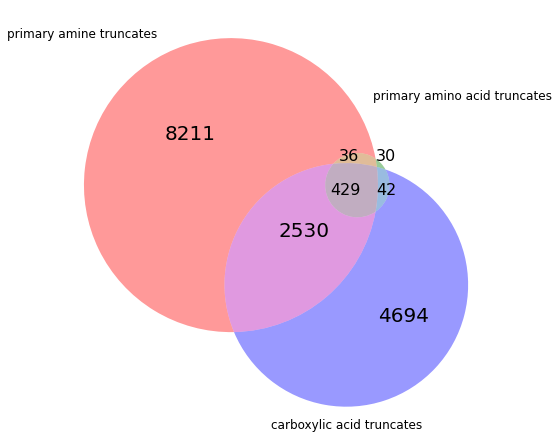

In [143]:
from matplotlib_venn import venn2, venn3

# A: 100, B: 010, C: 110, D: 001, E: 101, F: 011, G: 111
# venn3(subsets=(1,2,3,4,5,6,7))

pAA_truncates = set(pAA_mw200['truncate_SMILES'])
pamine_truncates = set(pamine_mw200['truncate_SMILES'])
cooh_truncates = set(cooh_mw200['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.34, 0.22)) # green
v3_s.subset_labels[2].set_position((0.22, 0.22)) # yellow
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[5].set_position((0.34, 0.11)) # turquoise
v3_s.subset_labels[6].set_fontsize(16)
v3_s.subset_labels[6].set_position((0.21, 0.11)) # purple

#fig.savefig('figures/mw_200_venn.png')
#fig.savefig('figures/mw_200_venn.svg')

#### MW $\leq$ 250

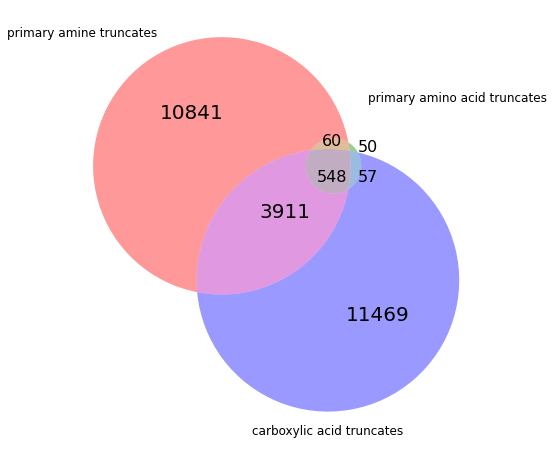

In [142]:
pAA_truncates = set(pAA_mw250['truncate_SMILES'])
pamine_truncates = set(pamine_mw250['truncate_SMILES'])
cooh_truncates = set(cooh_mw250['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.30, 0.25)) # green
v3_s.subset_labels[2].set_position((0.18, 0.27)) # yellow
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[5].set_position((0.30, 0.15)) # turquoise
v3_s.subset_labels[6].set_fontsize(16)
v3_s.subset_labels[6].set_position((0.18, 0.15)) # purple

#fig.savefig('figures/mw_250_venn.png')
#fig.savefig('figures/mw_250_venn.svg')

#### MW $\leq$ 300

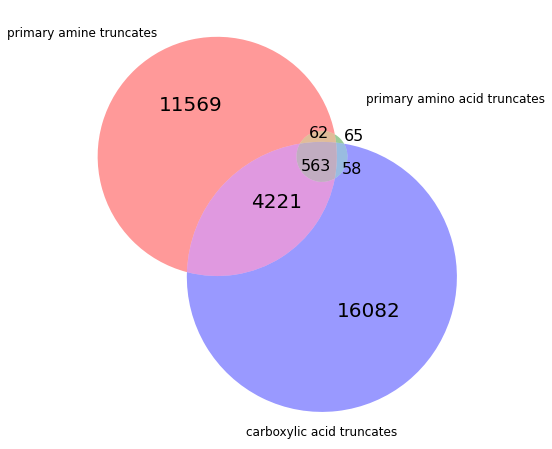

In [156]:
pAA_truncates = set(pAA_mw300['truncate_SMILES'])
pamine_truncates = set(pamine_mw300['truncate_SMILES'])
cooh_truncates = set(cooh_mw300['truncate_SMILES'])

fig, axs = plt.subplots(figsize=(8,8))
A_3 = pamine_truncates - (pAA_truncates | cooh_truncates)
B_3 = pAA_truncates - (pamine_truncates | cooh_truncates)
C_3 = (pamine_truncates & pAA_truncates) - cooh_truncates
D_3 = cooh_truncates - (pamine_truncates | pAA_truncates)
E_3 = (pamine_truncates & cooh_truncates) - pAA_truncates
F_3 = (pAA_truncates & cooh_truncates) - pamine_truncates
G_3 = pamine_truncates & pAA_truncates & cooh_truncates

v3_s = venn3(subsets=(len(A_3),len(B_3),len(C_3),len(D_3),len(E_3),len(F_3),len(G_3)), ax=axs)
v3_s.get_label_by_id('A').set_text('primary amine truncates')
v3_s.get_label_by_id('B').set_text('primary amino acid truncates')
v3_s.get_label_by_id('C').set_text('carboxylic acid truncates')
v3_s.get_label_by_id('B').set_position((0.3, 0.4))
v3_s.subset_labels[0].set_fontsize(20)
v3_s.subset_labels[1].set_fontsize(16)
v3_s.subset_labels[1].set_position((0.26, 0.29)) # green
v3_s.subset_labels[2].set_position((0.14, 0.30)) # yellow
v3_s.subset_labels[2].set_fontsize(16)
v3_s.subset_labels[3].set_fontsize(20)
v3_s.subset_labels[4].set_fontsize(20)
v3_s.subset_labels[5].set_fontsize(16)
v3_s.subset_labels[5].set_position((0.25, 0.18)) # turquoise
v3_s.subset_labels[6].set_fontsize(16)
v3_s.subset_labels[6].set_position((0.13, 0.19)) # purple

#fig.savefig('figures/mw_200_venn.png')
#fig.savefig('figures/mw_200_venn.svg')

In [157]:
pcp_val = np.zeros((4,3))
pcp_val[0][0] = len(set(pAA_mw200['truncate_SMILES']))
pcp_val[0][1] = len(set(pamine_mw200['truncate_SMILES']))
pcp_val[0][2] = len(set(cooh_mw200['truncate_SMILES']))

pcp_val[1][0] = len(set(pAA_mw250['truncate_SMILES']))
pcp_val[1][1] = len(set(pamine_mw250['truncate_SMILES']))
pcp_val[1][2] = len(set(cooh_mw250['truncate_SMILES']))

pcp_val[2][0] = len(set(pAA_mw300['truncate_SMILES']))
pcp_val[2][1] = len(set(pamine_mw300['truncate_SMILES']))
pcp_val[2][2] = len(set(cooh_mw300['truncate_SMILES']))

pcp_val[3][0] = len(set(pAA_umap['truncate_SMILES']))
pcp_val[3][1] = len(set(pamine_umap['truncate_SMILES']))
pcp_val[3][2] = len(set(cooh_umap['truncate_SMILES']))

array_to_latex.to_ltx(pcp_val, frmt='{:n}', arraytype='tabular')

\begin{tabular}
  537  &  11206  &  7695 \\
  715  &  15360  &  15985 \\
  748  &  16415  &  20924 \\
  764  &  17324  &  23687 
\end{tabular}


### Figure 5: Selection strategies

In [158]:
p_random = pamine_umap.sample(n=198, random_state=0)
c_random = cooh_umap.sample(n=198, random_state=0)

In [159]:
def uniform_sampling(df, cutoff):
    # source: https://gis.stackexchange.com/questions/436908/selecting-n-samples-uniformly-from-a-grid-points
    first = True
    list_ok = []
    smi_ok = []

    DISTANCE_MIN = cutoff

    for index, row in df.iterrows():
        if first:
            smi_ok.append(row['BB_SMILES'])
            list_ok.append([row['X'], row['Y']])
            first = False
            continue

        point = [row['X'], row['Y']]
        if any((euclidean(point, point_ok) < DISTANCE_MIN for point_ok in list_ok)):
            continue

        list_ok.append(point)
        smi_ok.append(row['BB_SMILES'])

    #df_out = pd.DataFrame(list_ok, columns=['X', 'Y'])
    df_out = pd.DataFrame(columns=['SMILES', 'X', 'Y'])
    df_out['SMILES'] = smi_ok
    df_out[['X', 'Y']] = list_ok
    
    return df_out

In [160]:
# Note that cutoff is NOT Tanimoto similarity, but rather euclidean distance in the UMAP space
p_unif = uniform_sampling(pamine_umap, cutoff=0.6)
print(len(p_unif))

c_unif = uniform_sampling(cooh_umap, cutoff=0.65)
print(len(c_unif))

218
214


In [161]:
# Need to create a list of bit vectors
pamine_umap['mol'] = [Chem.MolFromSmiles(smi) for smi in pamine_umap['truncate_SMILES']]
pamine_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in pamine_umap['mol']]

cooh_umap['mol'] = [Chem.MolFromSmiles(smi) for smi in cooh_umap['truncate_SMILES']]
cooh_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in cooh_umap['mol']]


In [199]:
mmp = SimDivFilters.MaxMinPicker()

help(mmp.LazyBitVectorPick)

Help on method LazyBitVectorPick:

LazyBitVectorPick(...) method of rdkit.SimDivFilters.rdSimDivPickers.MaxMinPicker instance
    LazyBitVectorPick( (MaxMinPicker)self, (AtomPairsParameters)objects, (int)poolSize, (int)pickSize [, (AtomPairsParameters)firstPicks=() [, (int)seed=-1 [, (AtomPairsParameters)useCache=None]]]) -> _vecti :
        Pick a subset of items from a pool of bit vectors using the MaxMin Algorithm
        Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598-604 
        ARGUMENTS:
        
          - vectors: a sequence of the bit vectors that should be picked from.
          - poolSize: number of items in the pool
          - pickSize: number of items to pick from the pool
          - firstPicks: (optional) the first items to be picked (seeds the list)
          - seed: (optional) seed for the random number generator
          - useCache: IGNORED.
        
    
        C++ signature :
            std::__1::vector<int, std::__1::allocator<int> > LazyBitVe

In [162]:
def minmaxpick(start_with, how_many, df):
    mmp = SimDivFilters.MaxMinPicker()
    picks = mmp.LazyBitVectorPick(df['fp'], len(df), start_with + how_many, list(range(start_with)))
    
    return [x for x in picks]

In [163]:
pamine_picks = minmaxpick(0, 198, pamine_umap)
cooh_picks = minmaxpick(0, 198, cooh_umap)

In [164]:
p_mmp = pamine_umap.iloc[pamine_picks]
c_mmp = cooh_umap.iloc[cooh_picks]

In [165]:
print(len(p_random))
print(len(p_unif[:198]))
print(len(p_mmp))

print(len(c_random))
print(len(c_unif[:198]))
print(len(c_mmp))

198
198
198
198
198
198


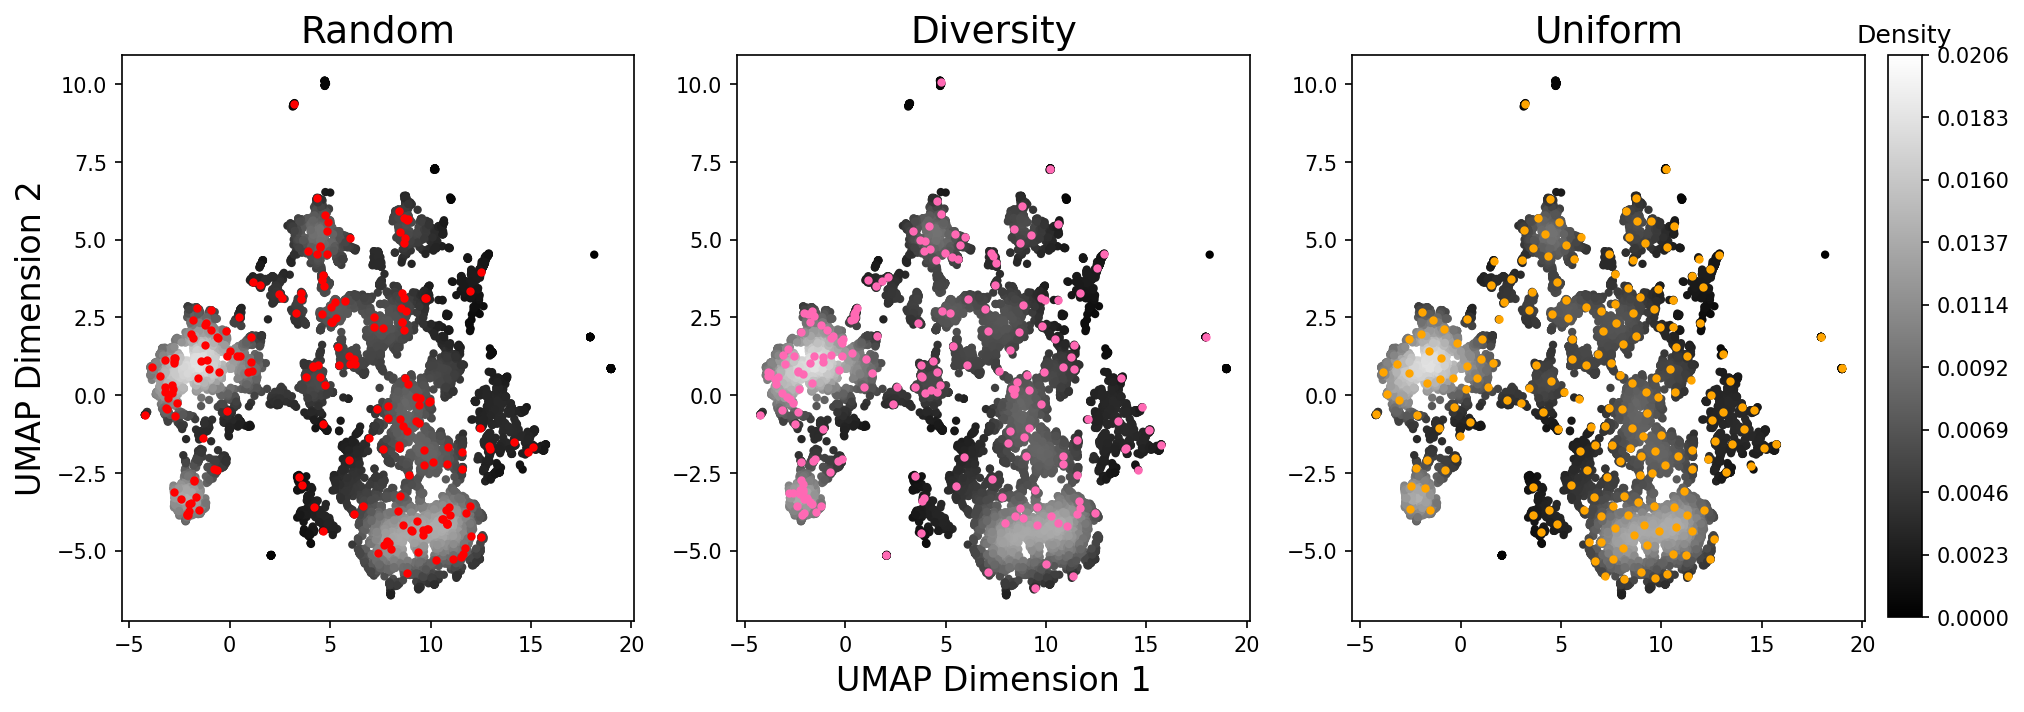

In [166]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=150)
sc = axs[0].scatter(pamine_umap['X'], pamine_umap['Y'], marker='.', c=z_pamine, cmap='gray',
              vmin=t_min, vmax=t_max)
axs[0].scatter(p_random['X'], p_random['Y'], marker='.', color='red', alpha=1)
axs[0].set_title('Random', fontsize=18)

axs[1].scatter(pamine_umap['X'], pamine_umap['Y'], marker='.', c=z_pamine, cmap='gray',
              vmin=t_min, vmax=t_max)
axs[1].scatter(p_mmp['X'], p_mmp['Y'], marker='.', color='hotpink')
axs[1].set_title('Diversity', fontsize=18)

axs[2].scatter(pamine_umap['X'], pamine_umap['Y'], marker='.', c=z_pamine, cmap='gray',
              vmin=t_min, vmax=t_max)
axs[2].scatter(p_unif['X'][:198], p_unif['Y'][:198], marker='.', color='orange')
axs[2].set_title('Uniform', fontsize=18)

cbar_ax = fig.add_axes([0.91, 0.13, 0.015, 0.75])
cbar_ax.set_title("Density")

cbar = plt.colorbar(sc, cbar_ax)
cbar.set_ticks(np.linspace(t_min, t_max, 10))
cbar.set_ticklabels([f"{x:.4f}" for x in np.linspace(t_min, t_max, 10)])

# axs[1][0].scatter(cooh_umap['X'], cooh_umap['Y'], marker='.', color='gray', alpha=0.1)
# axs[1][0].scatter(c_random['X'], c_random['Y'], marker='.', color='blue', alpha=1)
# axs[1][0].set_title('cooh random selection', fontsize=18)

# axs[1][1].scatter(cooh_umap['X'], cooh_umap['Y'], marker='.', color='gray', alpha=0.1)
# axs[1][1].scatter(c_mmp['X'], c_mmp['Y'], marker='.', color='aqua')
# axs[1][1].set_title('cooh diversity selection', fontsize=18)

# axs[1][2].scatter(cooh_umap['X'], cooh_umap['Y'], marker='.', color='gray', alpha=0.1)
# axs[1][2].scatter(c_unif['X'][:198], c_unif['Y'][:198], marker='.', color='deepskyblue')
# axs[1][2].set_title('cooh uniform selection', fontsize=18)

axs[0].set_ylabel('UMAP Dimension 2', fontsize=16)
axs[1].set_xlabel('UMAP Dimension 1', fontsize=16)

#fig.savefig('figures/figure_5.png')
#fig.savefig('figures/figure_5.svg')

plt.show()

### Library enumeration

Three design considerations:
1. cost filter
2. mw filter
3. selection strategy

#### Library 1: MW <= 200 and cost <= \$100 (most strict)

#### Library 2: MW <= 300 and cost <= \$500 (least strict)

In [167]:
#Check that there might be duplicates 
# (also performing both queries on original dataset does not give same subset) >:(

l1p1 = pamine_mw200.loc[pamine_mw200['Price_250mg'] <= 100]
l1p2 = cooh_mw200.loc[cooh_mw200['Price_250mg'] <= 100]

l2p1 = pamine_mw300.loc[pamine_umap['Price_250mg'] <= 500]
l2p2 = cooh_mw300.loc[cooh_umap['Price_250mg'] <= 500]

In [168]:
l1p1_unif = uniform_sampling(l1p1, cutoff=0.4)[:192]
print(len(l1p1_unif))

192


In [169]:
l1p2_unif = uniform_sampling(l1p2, cutoff=0.42)[:192]
print(len(l1p2_unif))

192


In [170]:
l2p1_unif = uniform_sampling(l2p1, cutoff=0.6)[:192]
print(len(l2p1_unif))

192


In [171]:
l2p2_unif = uniform_sampling(l2p2, cutoff=0.65)[:192]
print(len(l2p2_unif))

192


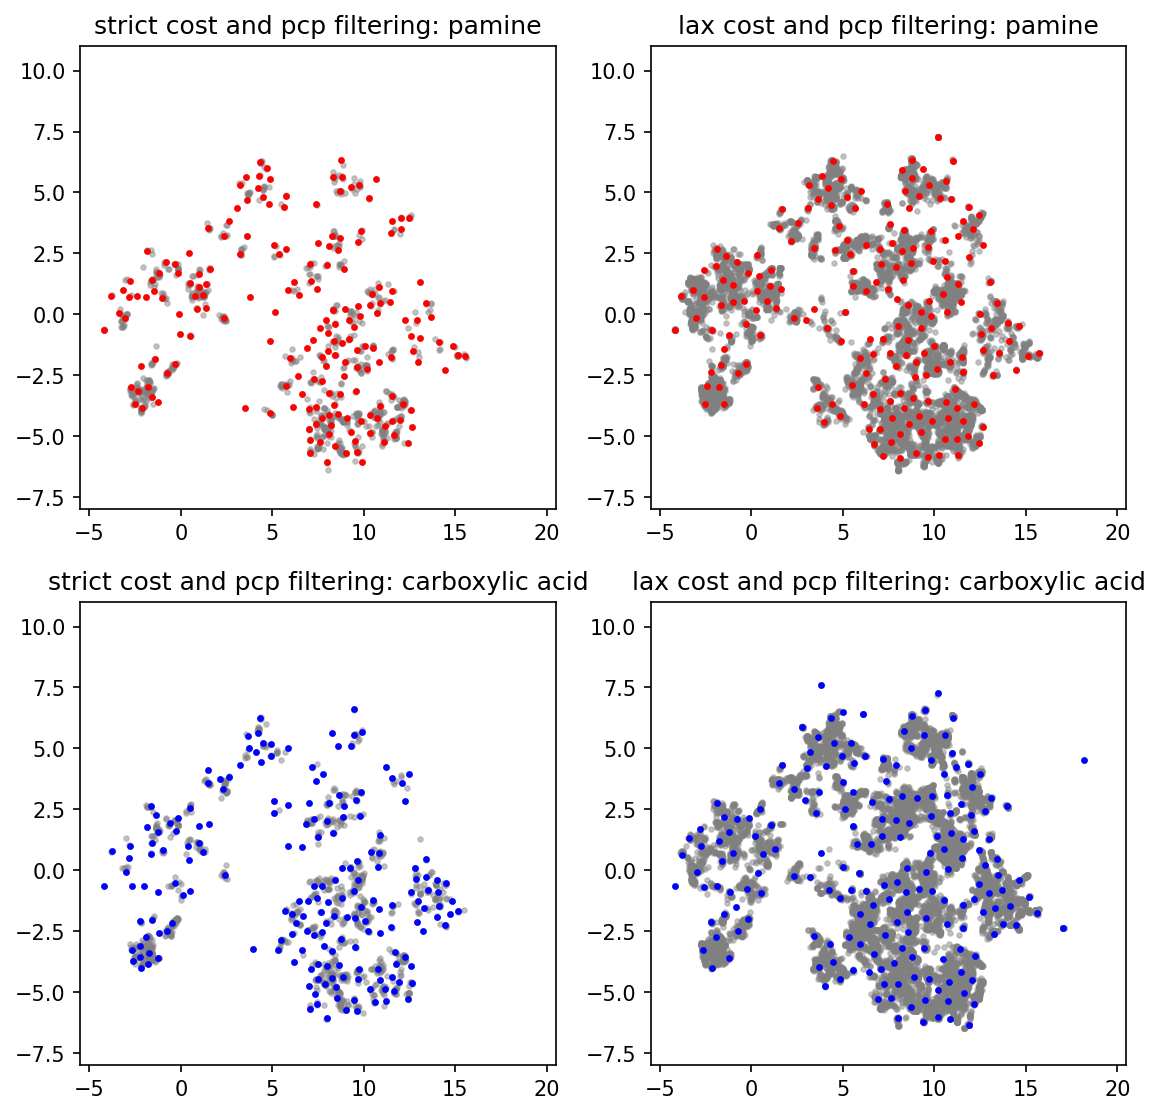

In [172]:
fig, axs = plt.subplots(2, 2, figsize=(9,9), dpi=150)
for ax in axs.reshape(-1):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

axs[0][0].scatter(l1p1['X'], l1p1['Y'], s=5, color='gray', alpha=0.4)
axs[0][0].scatter(l1p1_unif['X'], l1p1_unif['Y'], s=5, color='red')
axs[0][0].set_title('strict cost and pcp filtering: pamine')

axs[0][1].scatter(l2p1['X'], l2p1['Y'], s=5, color='gray', alpha=0.4)
axs[0][1].scatter(l2p1_unif['X'], l2p1_unif['Y'], s=5, color='red')
axs[0][1].set_title('lax cost and pcp filtering: pamine')

axs[1][0].scatter(l1p2['X'], l1p2['Y'], s=5, color='gray', alpha=0.4)
axs[1][0].scatter(l1p2_unif['X'], l1p2_unif['Y'], s=5, color='blue')
axs[1][0].set_title('strict cost and pcp filtering: carboxylic acid')

axs[1][1].scatter(l2p2['X'], l2p2['Y'], s=5, color='gray', alpha=0.4)
axs[1][1].scatter(l2p2_unif['X'], l2p2_unif['Y'], s=5, color='blue')
axs[1][1].set_title('lax cost and pcp filtering: carboxylic acid')
plt.show()

In [173]:
def lib_enum(pamine_selection, cooh_selection):
    libgen = oechem.OELibraryGen('[#6:1][N:2]([H:3])[H:4].[#6:10](=[O:11])[O:12][H:13]>>[#6:1][N:2]([H:3])[#6:10](=[O:11])')

    products = []
    tracker = {}
    for i in range(len(pamine_selection)):
        for j in range(len(cooh_selection)):
            pamine_bb = pamine_selection['SMILES'].iloc[i]
            cooh_bb = cooh_selection['SMILES'].iloc[j]

            mol = oechem.OEGraphMol()
            oechem.OEParseSmiles(mol, pamine_bb)
            libgen.SetStartingMaterial(mol, 0)

            mol.Clear()
            oechem.OEParseSmiles(mol, cooh_bb)
            libgen.SetStartingMaterial(mol, 1)

            k = 0
            for product in libgen.GetProducts():
                k += 1
                smi = oechem.OECreateCanSmiString(product)
                products.append(smi)
                
            tracker[f'({i},{j})'] = k
    return products, tracker

In [174]:
lib1, track1 = lib_enum(l1p1_unif, l1p2_unif)
print(len(lib1))

38016


In [175]:
lib2, track2 = lib_enum(l2p1_unif, l2p2_unif)
print(len(lib2))

38208


In [176]:
def make_molecules(df):
    molecules = []
    for iso_smi in df['SMILES']:
        mol = oechem.OEMol()
        oechem.OESmilesToMol(mol, iso_smi)
        molecules.append(mol)
    return molecules

In [177]:
library_1 = pd.DataFrame(lib1, columns=["SMILES"])

library_mols = make_molecules(library_1)
library_1['molecules'] = library_mols
library_1['mw'] = library_1['molecules'].apply(oechem.OECalculateMolecularWeight)
#library['xlogp'] = library['molecules'].apply(oemolprop.OEGetXLogP)
library_1['tpsa'] = library_1['molecules'].apply(oemolprop.OEGet2dPSA)
library_1['hbd'] = library_1['molecules'].apply(oemolprop.OEGetHBondDonorCount)

In [178]:
xlogp = np.ones(len(library_1)) * -100
for i in range(len(library_1)):
    mol = library_1['molecules'].iloc[i]
    try:
        xlogp[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
    
library_1['xlogp'] = xlogp

In [179]:
library_2 = pd.DataFrame(lib2, columns=["SMILES"])

library_mols = make_molecules(library_2)
library_2['molecules'] = library_mols
library_2['mw'] = library_2['molecules'].apply(oechem.OECalculateMolecularWeight)
#library['xlogp'] = library['molecules'].apply(oemolprop.OEGetXLogP)
library_2['tpsa'] = library_2['molecules'].apply(oemolprop.OEGet2dPSA)
library_2['hbd'] = library_2['molecules'].apply(oemolprop.OEGetHBondDonorCount)

In [180]:
xlogp_2 = np.ones(len(library_2)) * -100
for i in range(len(library_2)):
    mol = library_2['molecules'].iloc[i]
    try:
        xlogp_2[i] = oemolprop.OEGetXLogP(mol)
    except:
        pass
    
library_2['xlogp'] = xlogp_2

### Cost 

In [193]:
l1p1_cost = np.sum(pd.merge(l1p1, l1p1_unif))['Price_250mg']
l1p2_cost = np.sum(pd.merge(l1p2, l1p2_unif))['Price_250mg']
print(l1p1_cost)
print(l1p2_cost)

10441.0
8722.0


In [194]:
l2p1_cost = np.sum(pd.merge(l2p1, l2p1_unif))['Price_250mg']
l2p2_cost = np.sum(pd.merge(l2p2, l2p2_unif))['Price_250mg']
print(l2p1_cost)
print(l2p2_cost)

40612.0
30522.0


### Building Block Similarity

In [183]:
l1p1_unif['mol'] = l1p1_unif['SMILES'].apply(Chem.MolFromSmiles)
l1p1_unif['fp'] = l1p1_unif['mol'].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048))

l1p2_unif['mol'] = l1p2_unif['SMILES'].apply(Chem.MolFromSmiles)
l1p2_unif['fp'] = l1p2_unif['mol'].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048))

l2p1_unif['mol'] = l2p1_unif['SMILES'].apply(Chem.MolFromSmiles)
l2p1_unif['fp'] = l2p1_unif['mol'].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048))

l2p2_unif['mol'] = l2p2_unif['SMILES'].apply(Chem.MolFromSmiles)
l2p2_unif['fp'] = l2p2_unif['mol'].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048))


In [184]:
def sim_mat(ref_df, test_df):
    sim_matrix = np.zeros((len(ref_df), len(test_df)), dtype=np.float32)
    for i, ref in enumerate(list(ref_df['fp'])):
        for j, test in enumerate(list(test_df['fp'])):
            sim_matrix[i,j] = DataStructs.TanimotoSimilarity(ref,test)
    np.fill_diagonal(sim_matrix, 0)
    return sim_matrix

In [185]:
l1p1_sim = sim_mat(l1p1_unif, l1p1_unif)
l1p2_sim = sim_mat(l1p2_unif, l1p2_unif)
l2p1_sim = sim_mat(l2p1_unif, l2p1_unif)
l2p2_sim = sim_mat(l2p2_unif, l2p2_unif)

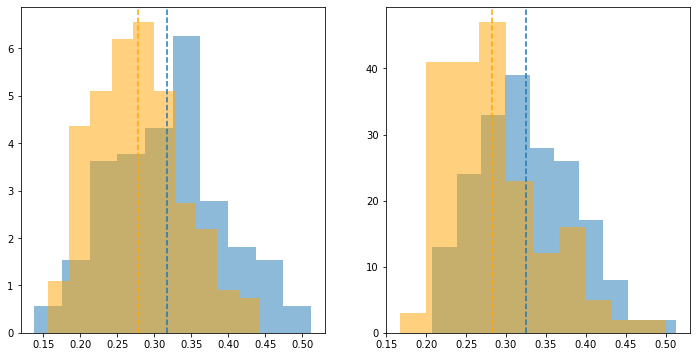

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].hist(np.max(l1p1_sim, axis=1), alpha=0.5, density=True)
axs[0].axvline(x=np.mean(np.max(l1p1_sim, axis=1)), linestyle='dashed')
axs[0].hist(np.max(l2p1_sim, axis=1), alpha=0.5, density=True, color='orange')
axs[0].axvline(x=np.mean(np.max(l2p1_sim, axis=1)), linestyle='dashed', color='orange')

axs[1].hist(np.max(l1p2_sim, axis=1), alpha=0.5)
axs[1].axvline(x=np.mean(np.max(l1p2_sim, axis=1)), linestyle='dashed')
axs[1].hist(np.max(l2p2_sim, axis=1), alpha=0.5, color='orange')
axs[1].axvline(x=np.mean(np.max(l2p2_sim, axis=1)), linestyle='dashed', color='orange')

plt.show()

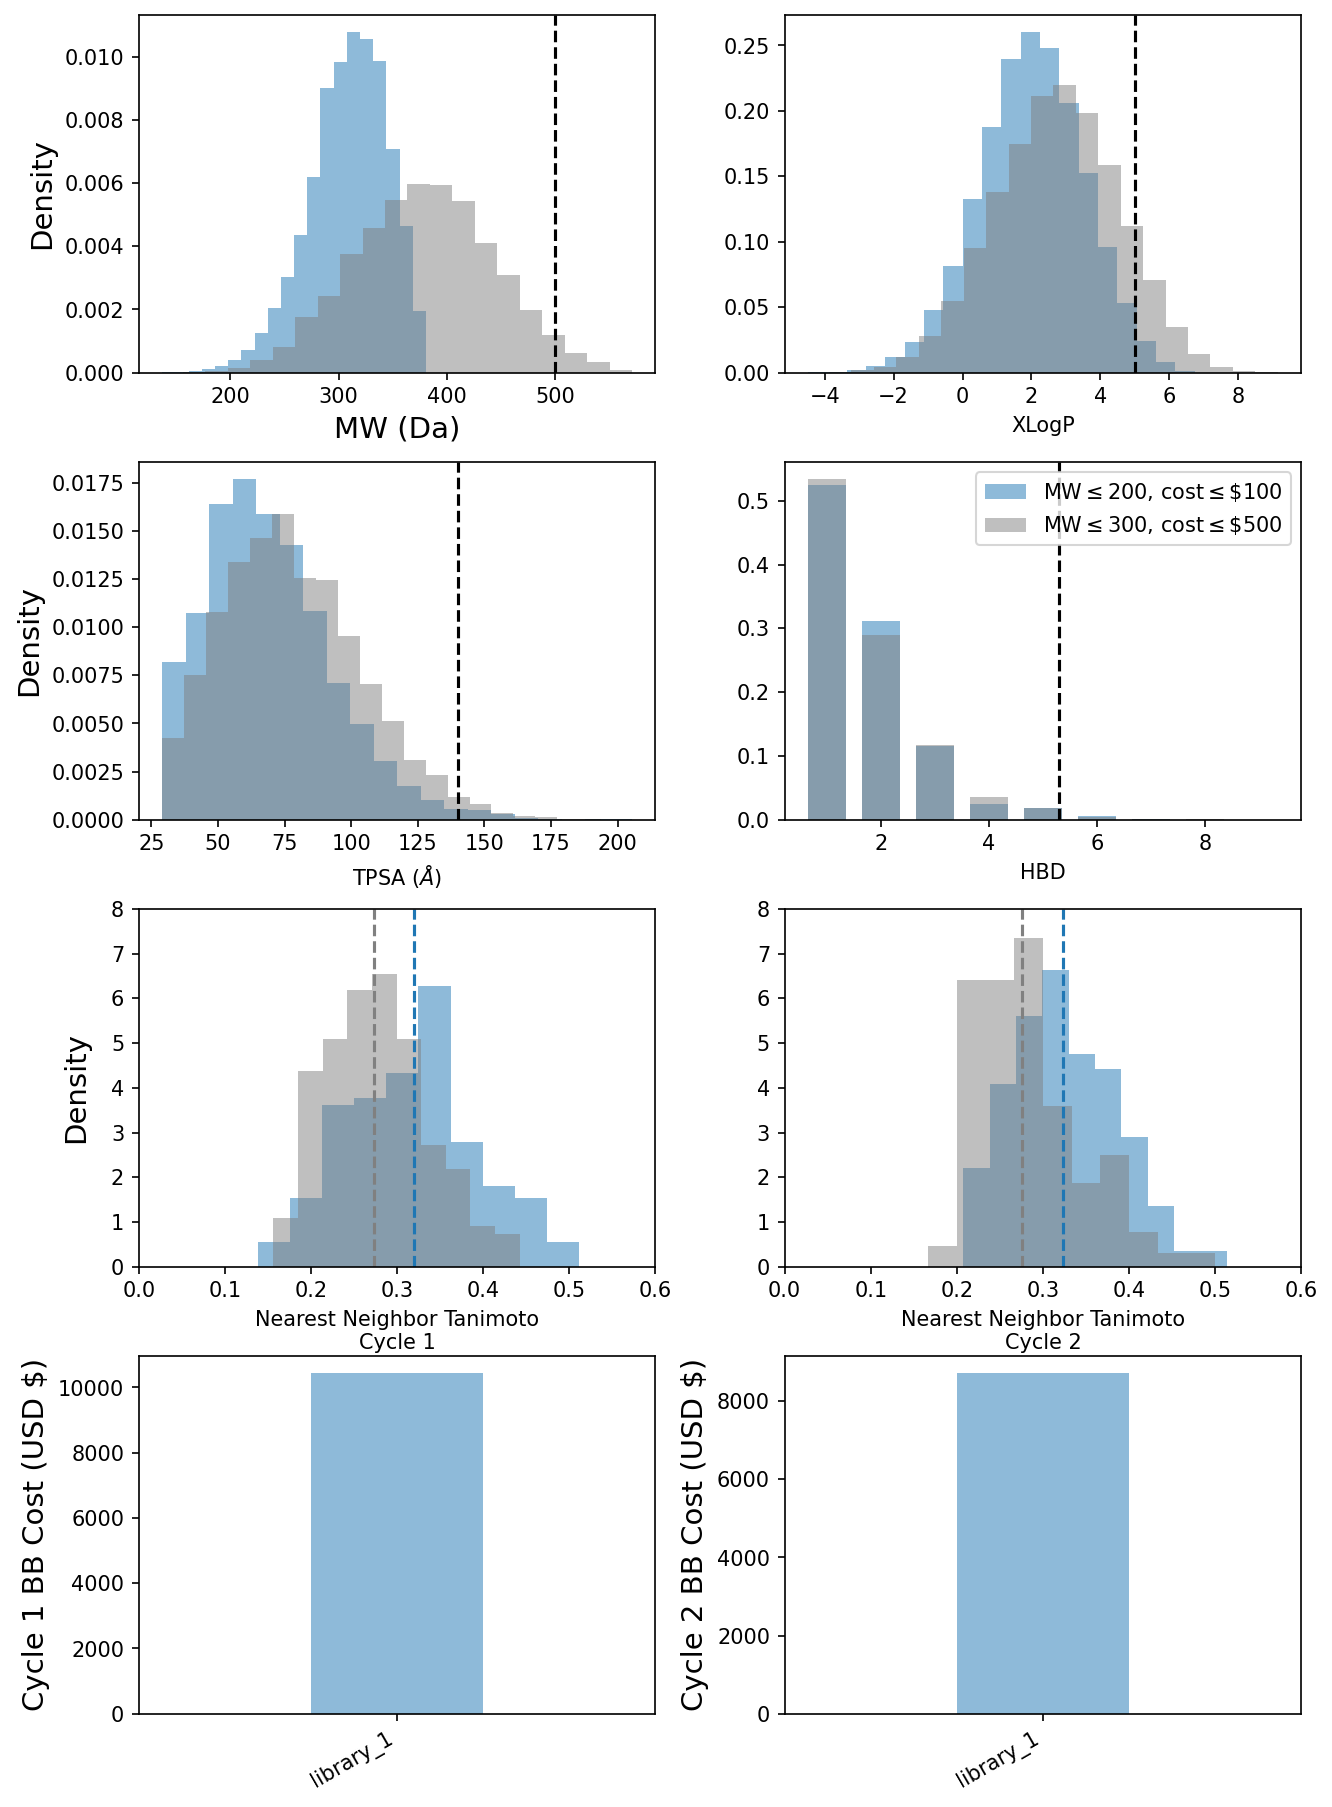

In [211]:
fig, axs = plt.subplots(4, 2, figsize=(10,15), dpi=150)
fig.subplots_adjust(hspace=0.25, wspace=0.25)
axs[0][0].hist(library_1['mw'], bins=20, alpha=0.5, density=True,
              label='MW$\leq$200, cost$\leq$\$100')
axs[0][0].hist(library_2['mw'], bins=20, alpha=0.5, density=True, color='gray',
              label='MW$\leq$300, cost$\leq$\$500')
axs[0][0].axvline(x=500, color='black', linestyle='dashed')
axs[0][0].set_xlabel('MW (Da)', fontsize=14)
#axs[0][0].legend(loc='best')

axs[0][1].hist(library_1.loc[library_1['xlogp'] > -100, 'xlogp'], bins=20, alpha=0.5, density=True,
              label='MW$\leq$200, cost$\leq$\$100')
axs[0][1].hist(library_2.loc[library_2['xlogp'] > -100, 'xlogp'], bins=20, alpha=0.5, density=True, color='gray',
              label='MW$\leq$300, cost$\leq$\$500')
axs[0][1].axvline(x=5, color='black', linestyle='dashed')
axs[0][1].set_xlabel('XLogP')
#axs[0][1].legend(loc='best')

axs[1][0].hist(library_1['tpsa'], bins=20, alpha=0.5, density=True,
              label='MW$\leq$200, cost$\leq$\$100')
axs[1][0].hist(library_2['tpsa'], bins=20, alpha=0.5, density=True, color='gray',
              label='MW$\leq$300, cost$\leq$\$500')
axs[1][0].axvline(x=140, color='black', linestyle='dashed')
axs[1][0].set_xlabel('TPSA ($\AA$)')
#axs[1][0].legend(loc='best')

axs[1][1].hist(library_1['hbd'], bins=np.arange(0.5, np.max(library_1['hbd'])+1.5), rwidth=0.7, 
               alpha=0.5, density=True, label='MW$\leq$200, cost$\leq$\$100')
axs[1][1].hist(library_2['hbd'], bins=np.arange(0.5, np.max(library_2['hbd'])+1.5), rwidth=0.7, 
               alpha=0.5, density=True, color='gray', label='MW$\leq$300, cost$\leq$\$500')
axs[1][1].axvline(x=5.3, color='black', linestyle='dashed')
axs[1][1].set_xlabel('HBD')
axs[1][1].legend(loc='best')

axs[2][0].hist(np.max(l1p1_sim, axis=1), alpha=0.5, density=True, label='MW$\leq$200, cost$\leq$\$100')
axs[2][0].axvline(x=np.median(np.max(l1p1_sim, axis=1)), linestyle='dashed')
axs[2][0].hist(np.max(l2p1_sim, axis=1), alpha=0.5, density=True, color='gray', label='MW$\leq$300, cost$\leq$\$500')
axs[2][0].axvline(x=np.median(np.max(l2p1_sim, axis=1)), linestyle='dashed', color='gray')
#axs[2][0].legend(loc='best')
axs[2][0].set_xlabel('Nearest Neighbor Tanimoto\nCycle 1')

axs[2][0].set_ylim([0, 8])
axs[2][1].set_ylim([0, 8])
axs[2][0].set_xlim([0, 0.6])
axs[2][1].set_xlim([0, 0.6])

axs[2][1].hist(np.max(l1p2_sim, axis=1), alpha=0.5, density=True, label='MW$\leq$200, cost$\leq$\$100')
axs[2][1].axvline(x=np.median(np.max(l1p2_sim, axis=1)), linestyle='dashed')
axs[2][1].hist(np.max(l2p2_sim, axis=1), alpha=0.5, density=True, color='gray', label='MW$\leq$300, cost$\leq$\$500')
axs[2][1].axvline(x=np.median(np.max(l2p2_sim, axis=1)), linestyle='dashed', color='gray')
#axs[2][1].legend(loc='best')
axs[2][1].set_xlabel('Nearest Neighbor Tanimoto\nCycle 2')

axs[0][0].set_ylabel('Density', fontsize=14)
axs[1][0].set_ylabel('Density', fontsize=14)
axs[2][0].set_ylabel('Density', labelpad=10, fontsize=14)

axs[3][0].bar(x=0.5, height=l1p1_cost, width=1, alpha=0.5)
axs[3][0].set_xticks([0.5])
axs[3][0].set_xticklabels(['library_1'], rotation=30, ha='right')
axs[3][0].set_xlim([-1, 2])
axs[3][0].set_ylabel('Cycle 1 BB Cost (USD $)', fontsize=14)

axs[3][1].bar(x=0.5, height=l1p2_cost, width=1, alpha=0.5)
axs[3][1].set_xticks([0.5])
axs[3][1].set_xticklabels(['library_1'], rotation=30, ha='right')
axs[3][1].set_xlim([-1, 2])
axs[3][1].set_ylabel('Cycle 2 BB Cost (USD $)', fontsize=14)

# axs[2][0].bar(x=0, height=l1p1_cost + l1p2_cost, alpha=0.5)
# axs[2][0].bar(x=1, height=l2p1_cost + l2p2_cost, color='orange', alpha=0.5)
# axs[2][0].set_xticks(np.arange(0,2))
# axs[2][0].set_xticklabels(['', ''])
# axs[2][0].set_ylabel('Total cost ($)', fontsize=14)

#fig.savefig('../figures/figure_6.png', bbox_inches='tight')
#fig.savefig('figures/figure_6.svg')

plt.show()

In [191]:
print('Molecular Weight Medians')
print('Library 1:', np.median(library_1['mw']))
print('Library 2:', np.median(library_2['mw']))
print('')
print('XLogP Medians')
print('Library 1:', np.median(library_1['xlogp']))
print('Library 2:', np.median(library_2['xlogp']))
print('')
print('TPSA Medians')
print('Library 1:', np.median(library_1['tpsa']))
print('Library 2:', np.median(library_2['tpsa']))
print('')
print('HBD Medians')
print('Library 1:', np.median(library_1['hbd']))
print('Library 2:', np.median(library_2['hbd']))
print('')
print('Cycle 1 Similarity Medians')
print('Library 1:', np.median(np.max(l1p1_sim, axis=1)))
print('Library 2:', np.median(np.max(l2p1_sim, axis=1)))
print('')
print('Cycle 2 Similarity Medians')
print('Library 1:', np.median(np.max(l1p2_sim, axis=1)))
print('Library 2:', np.median(np.max(l2p2_sim, axis=1)))

Molecular Weight Medians
Library 1: 312.36629999999997
Library 2: 379.5184

XLogP Medians
Library 1: 2.0320000648498535
Library 2: 2.7795000076293945

TPSA Medians
Library 1: 67.07999801635742
Library 2: 75.5999984741211

HBD Medians
Library 1: 1.0
Library 2: 1.0

Cycle 1 Similarity Medians
Library 1: 0.31914893
Library 2: 0.27272728

Cycle 2 Similarity Medians
Library 1: 0.32352942
Library 2: 0.27561218


In [192]:
print(np.mean((np.max(l1p2_sim, axis=1))))
print(np.mean(np.max(l2p2_sim, axis=1)))

0.32472965
0.2827164
